# 时间序列分析第十一次作业
作业任务：神经网络  
数据选择高频1分钟数据  
感觉MLP和LSTM太简单了，尝试了一下组合CNN-BiLSTM-Attention和CNN-BiGRU-Attention，优点就是确实准，缺点就是太容易过拟合了  
还尝试了优化算法优化超参数

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、数据导入与探索
标普500的2017年全年分时数据，频率为分钟  
数据来源：histdata

标普500数据形状 (222026, 5)
标普500数据概览
                        open     high      low    close    price
date                                                            
2017-01-02 18:00:00  2241.00  2244.50  2241.00  2243.50  2243.50
2017-01-02 18:01:00  2243.75  2243.75  2243.00  2243.00  2243.00
2017-01-02 18:02:00  2243.25  2243.25  2243.00  2243.25  2243.25
2017-01-02 18:03:00  2243.00  2243.00  2243.00  2243.00  2243.00
2017-01-02 18:04:00  2243.25  2243.75  2243.25  2243.75  2243.75
2017-01-02 18:05:00  2243.75  2244.00  2243.75  2243.75  2243.75
2017-01-02 18:06:00  2243.25  2243.50  2243.25  2243.25  2243.25
2017-01-02 18:07:00  2243.00  2243.25  2242.75  2242.75  2242.75
2017-01-02 18:08:00  2243.00  2243.00  2242.75  2242.75  2242.75
2017-01-02 18:09:00  2242.50  2242.75  2242.50  2242.75  2242.75
数据形状： (222026, 4)
-------------------------------------数据导入与探索已完成-------------------------------------


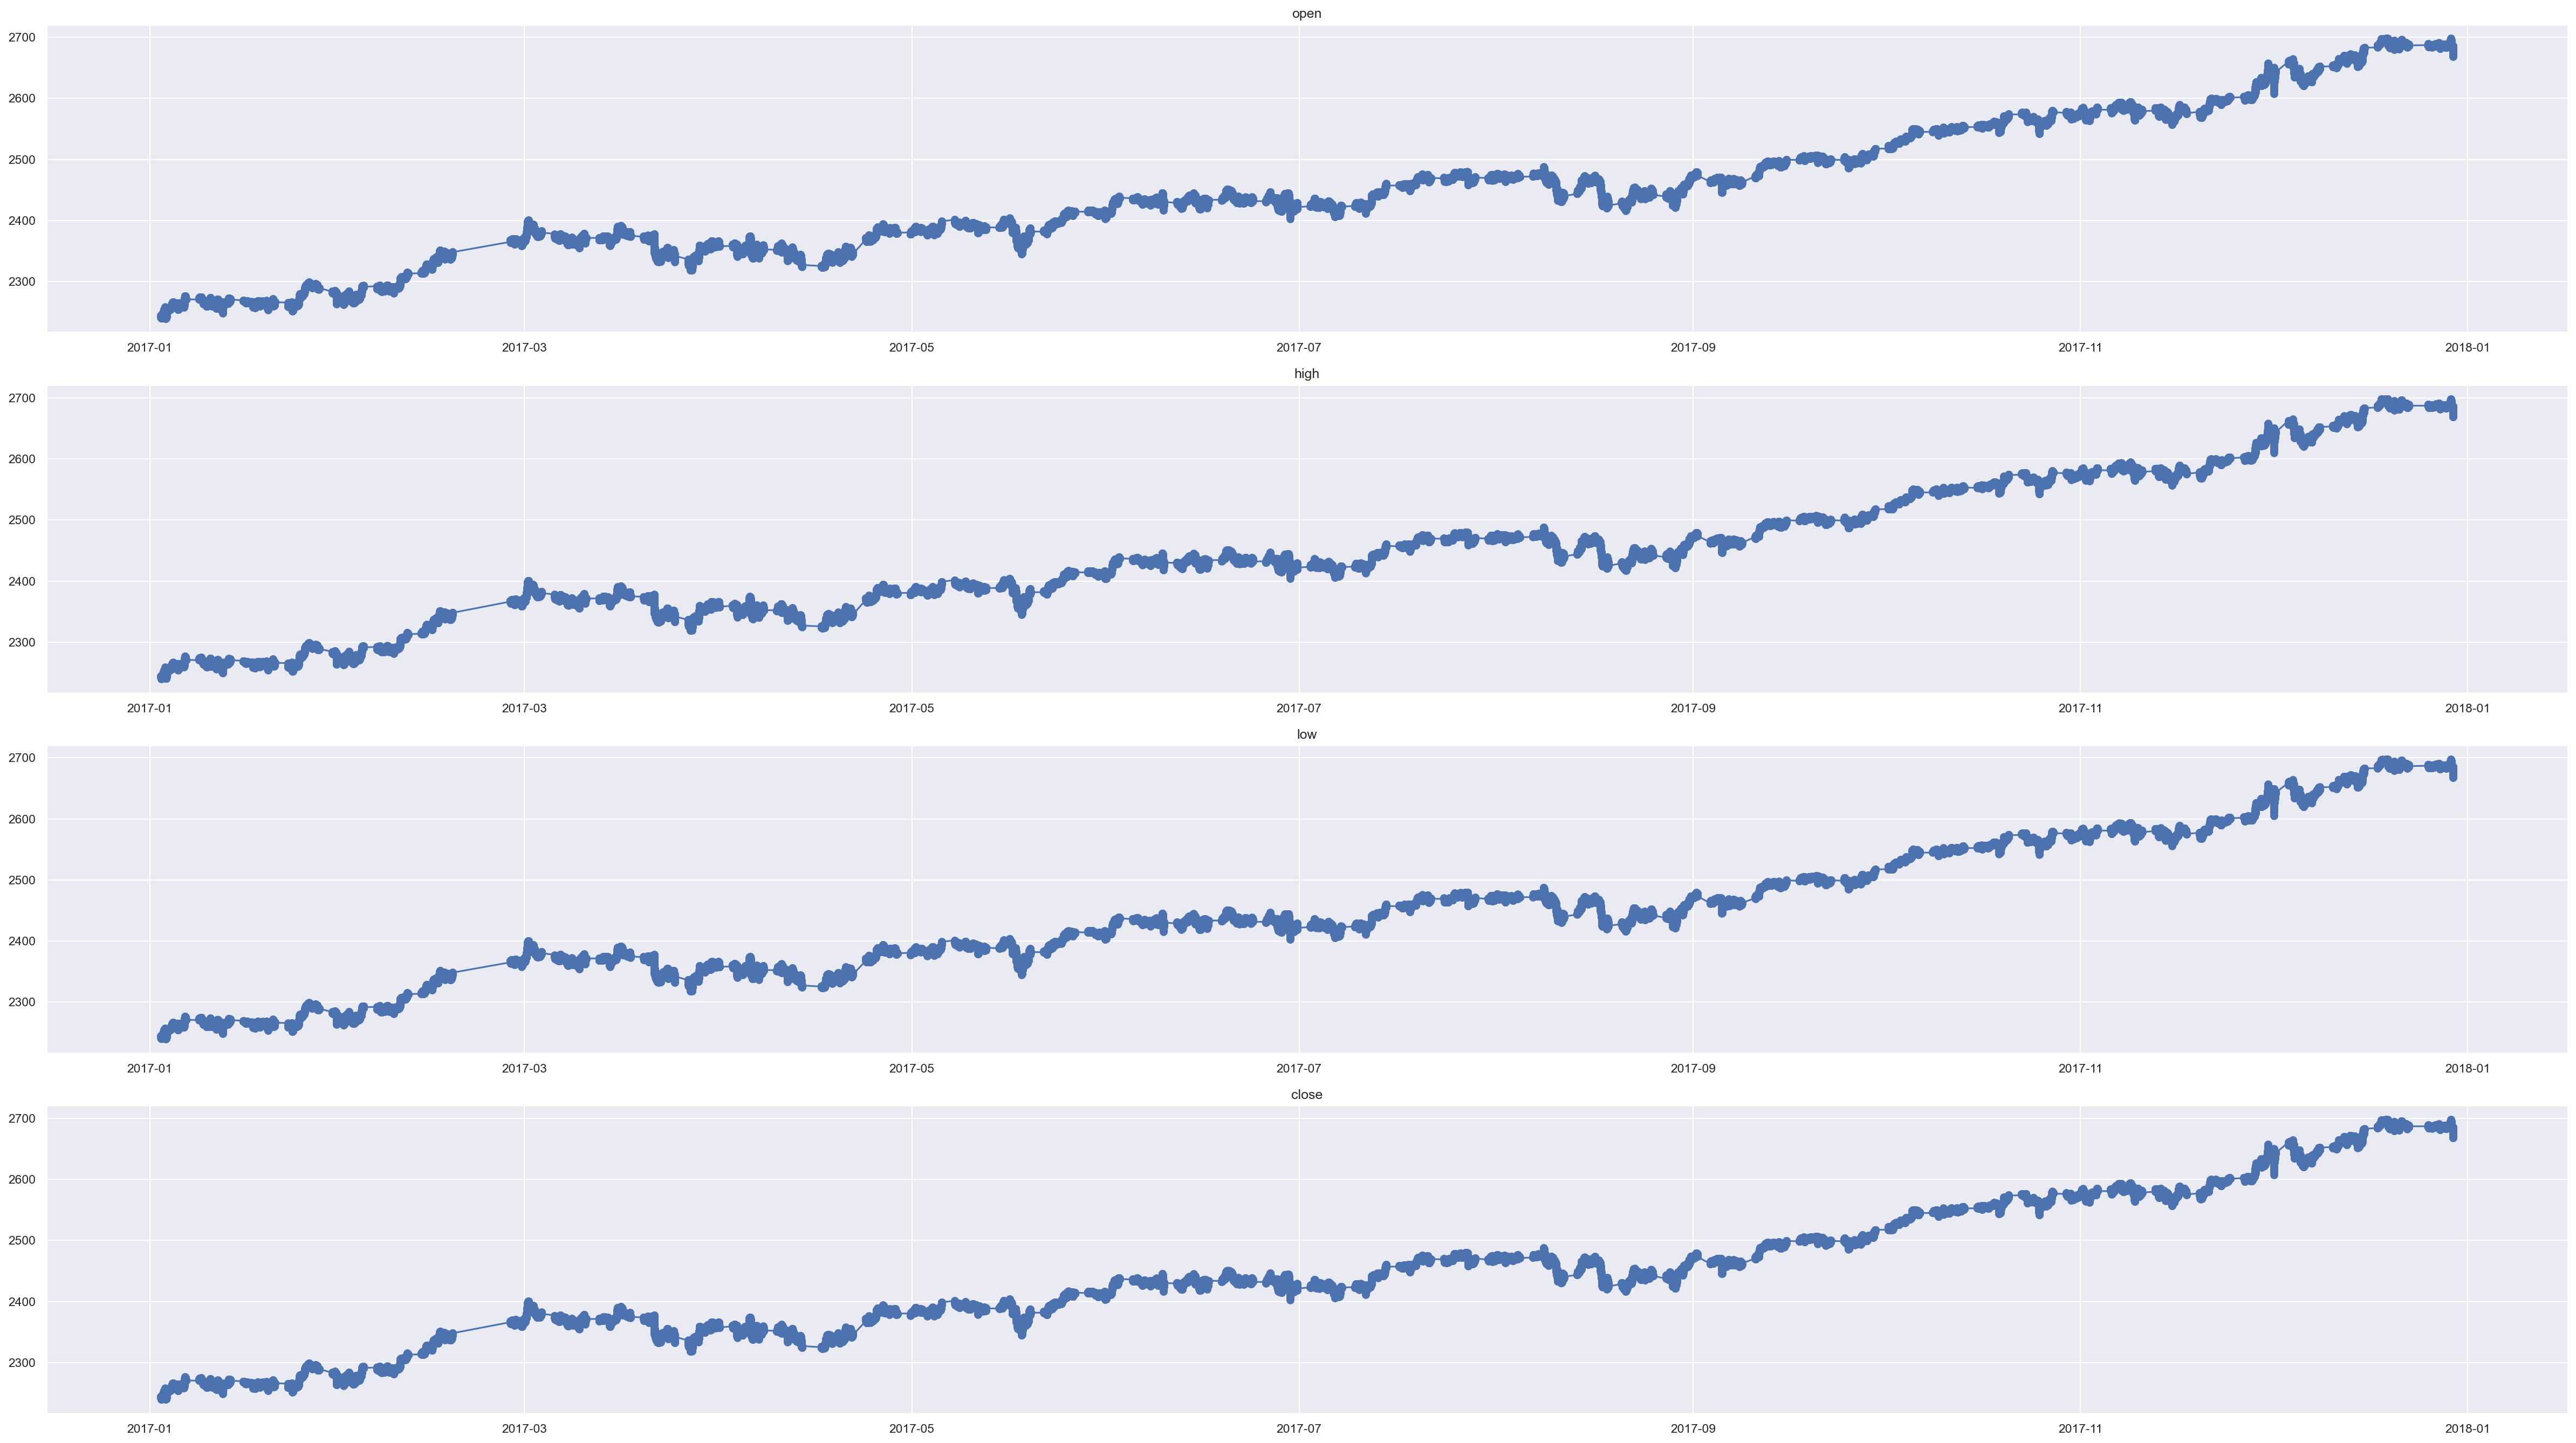

In [2]:
import pyfinancialdata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import warnings

warnings.filterwarnings("ignore")

####--------------------------------------1、数据导入与探索--------------------------------------####
# 标普500 2017年全年分时数据
# 数据来源：histdata
data = pyfinancialdata.get(provider='histdata', instrument='SPXUSD', year=2017)

# 数据形状
print('标普500数据形状', data.shape)

# 数据概览
print('标普500数据概览')
print(data.head(10))

# 剔除无关变量
data = data.drop(columns='price')

# 数据探索
sns.set_theme(font_scale=1)
plt.figure(figsize=(32, 18), dpi=150)

for i, column in enumerate(data.columns):
    plt.subplot(4, 1, i + 1)
    plt.plot(data[column], linestyle='-', color='b', marker='o', markerfacecolor='b')
    plt.title(column)

plt.tight_layout()
plt.savefig(fname='数据概览.png')

print('数据形状：', data.shape)
print('-------------------------------------数据导入与探索已完成-------------------------------------')

## 二、数据预处理
### 2.1 异常值检验与处理 

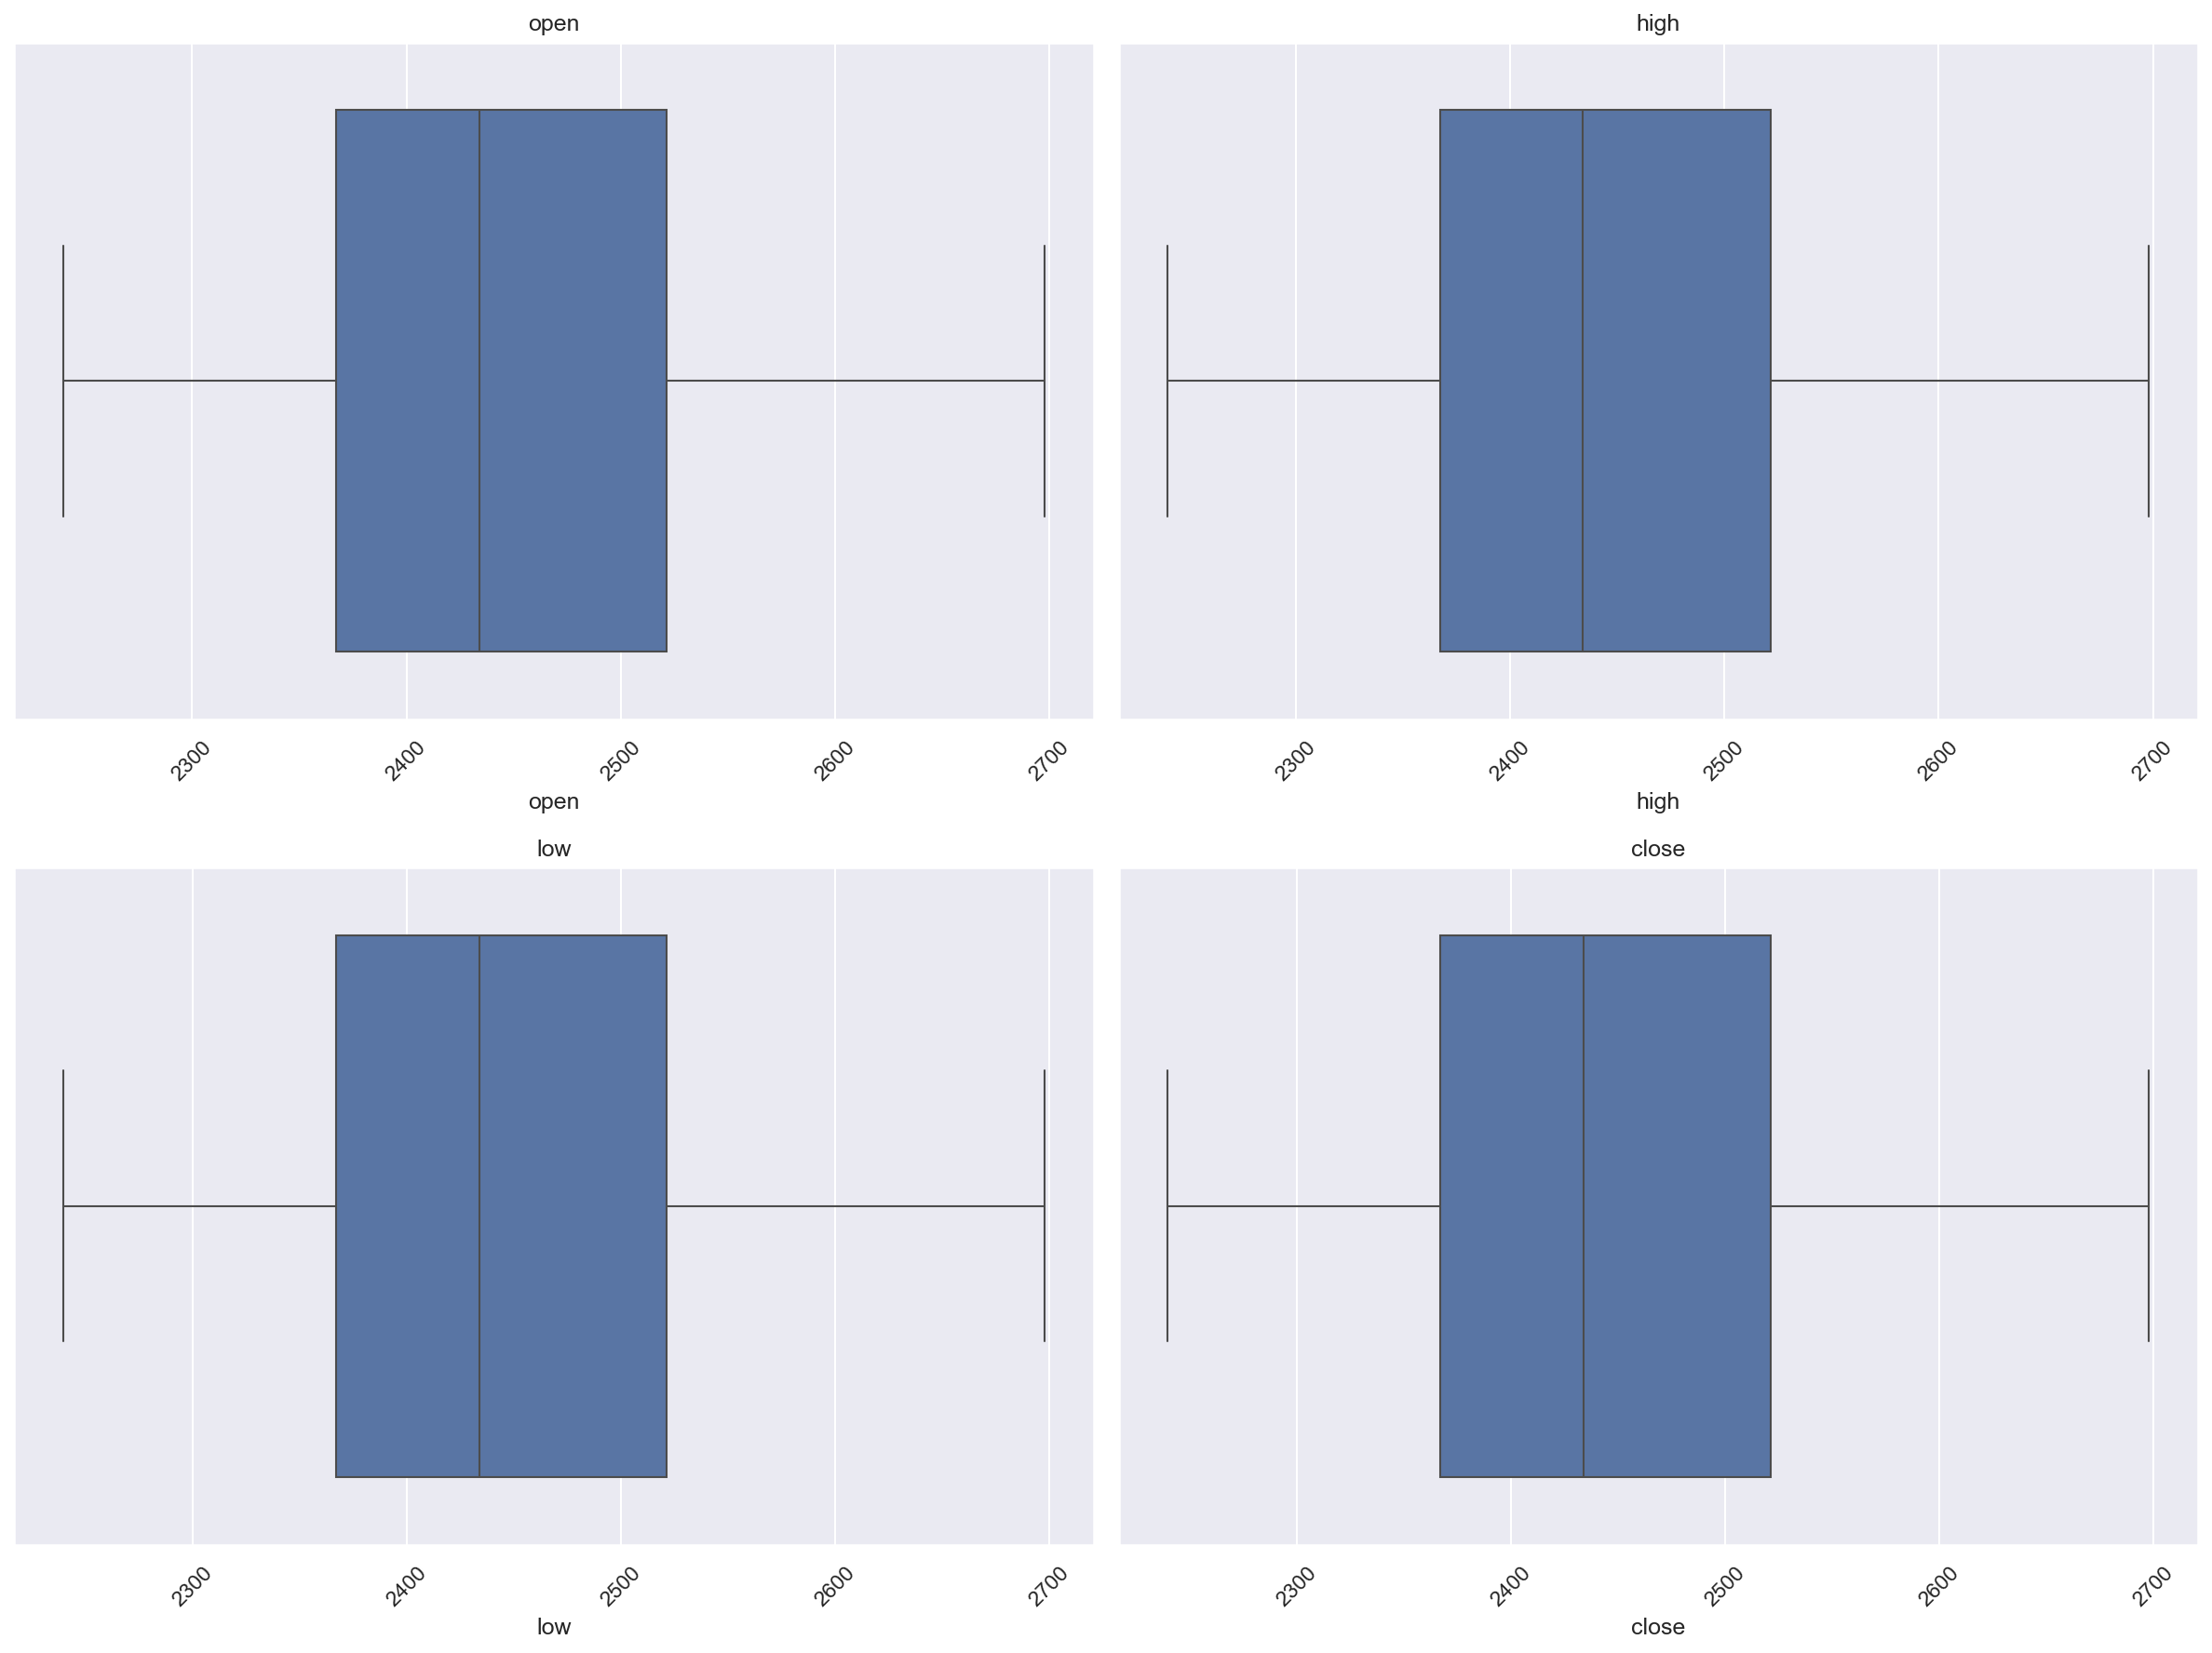

In [3]:
####--------------------------------------2、数据预处理--------------------------------------####
## 异常值检测与处理
# 箱线图
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), dpi = 150)
axes = axes.flatten()

for i, column in enumerate(data.columns):
    g_previous_box = sns.boxplot(data=data, x=column, ax=axes[i])
    axes[i].set_title(column)

    locator = axes[i].get_xticks()
    axes[i].xaxis.set_major_locator(plt.FixedLocator(locator))
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(fname="箱线图.png")

结论：无异常值
### 2.2 缺失值检验与处理

In [4]:

## 缺失值检测与处理
# 缺失比例
print('缺失值情况及比例：')
total_rows = data.shape[0]
missing_value_sums = data.isnull().sum()
missing_value_proportions = (missing_value_sums / total_rows) * 100

for column, missing_count in missing_value_sums.items():
    proportion = missing_value_proportions[column]
    print(f"{column}: 缺失值数量为 {missing_count}，缺失值比例为 {proportion:.2f}%")


缺失值情况及比例：
open: 缺失值数量为 0，缺失值比例为 0.00%
high: 缺失值数量为 0，缺失值比例为 0.00%
low: 缺失值数量为 0，缺失值比例为 0.00%
close: 缺失值数量为 0，缺失值比例为 0.00%


结论：无异常值
### 2.2 归一化

数据形状： (222026, 4)
-------------------------------------数据预处理已完成-------------------------------------


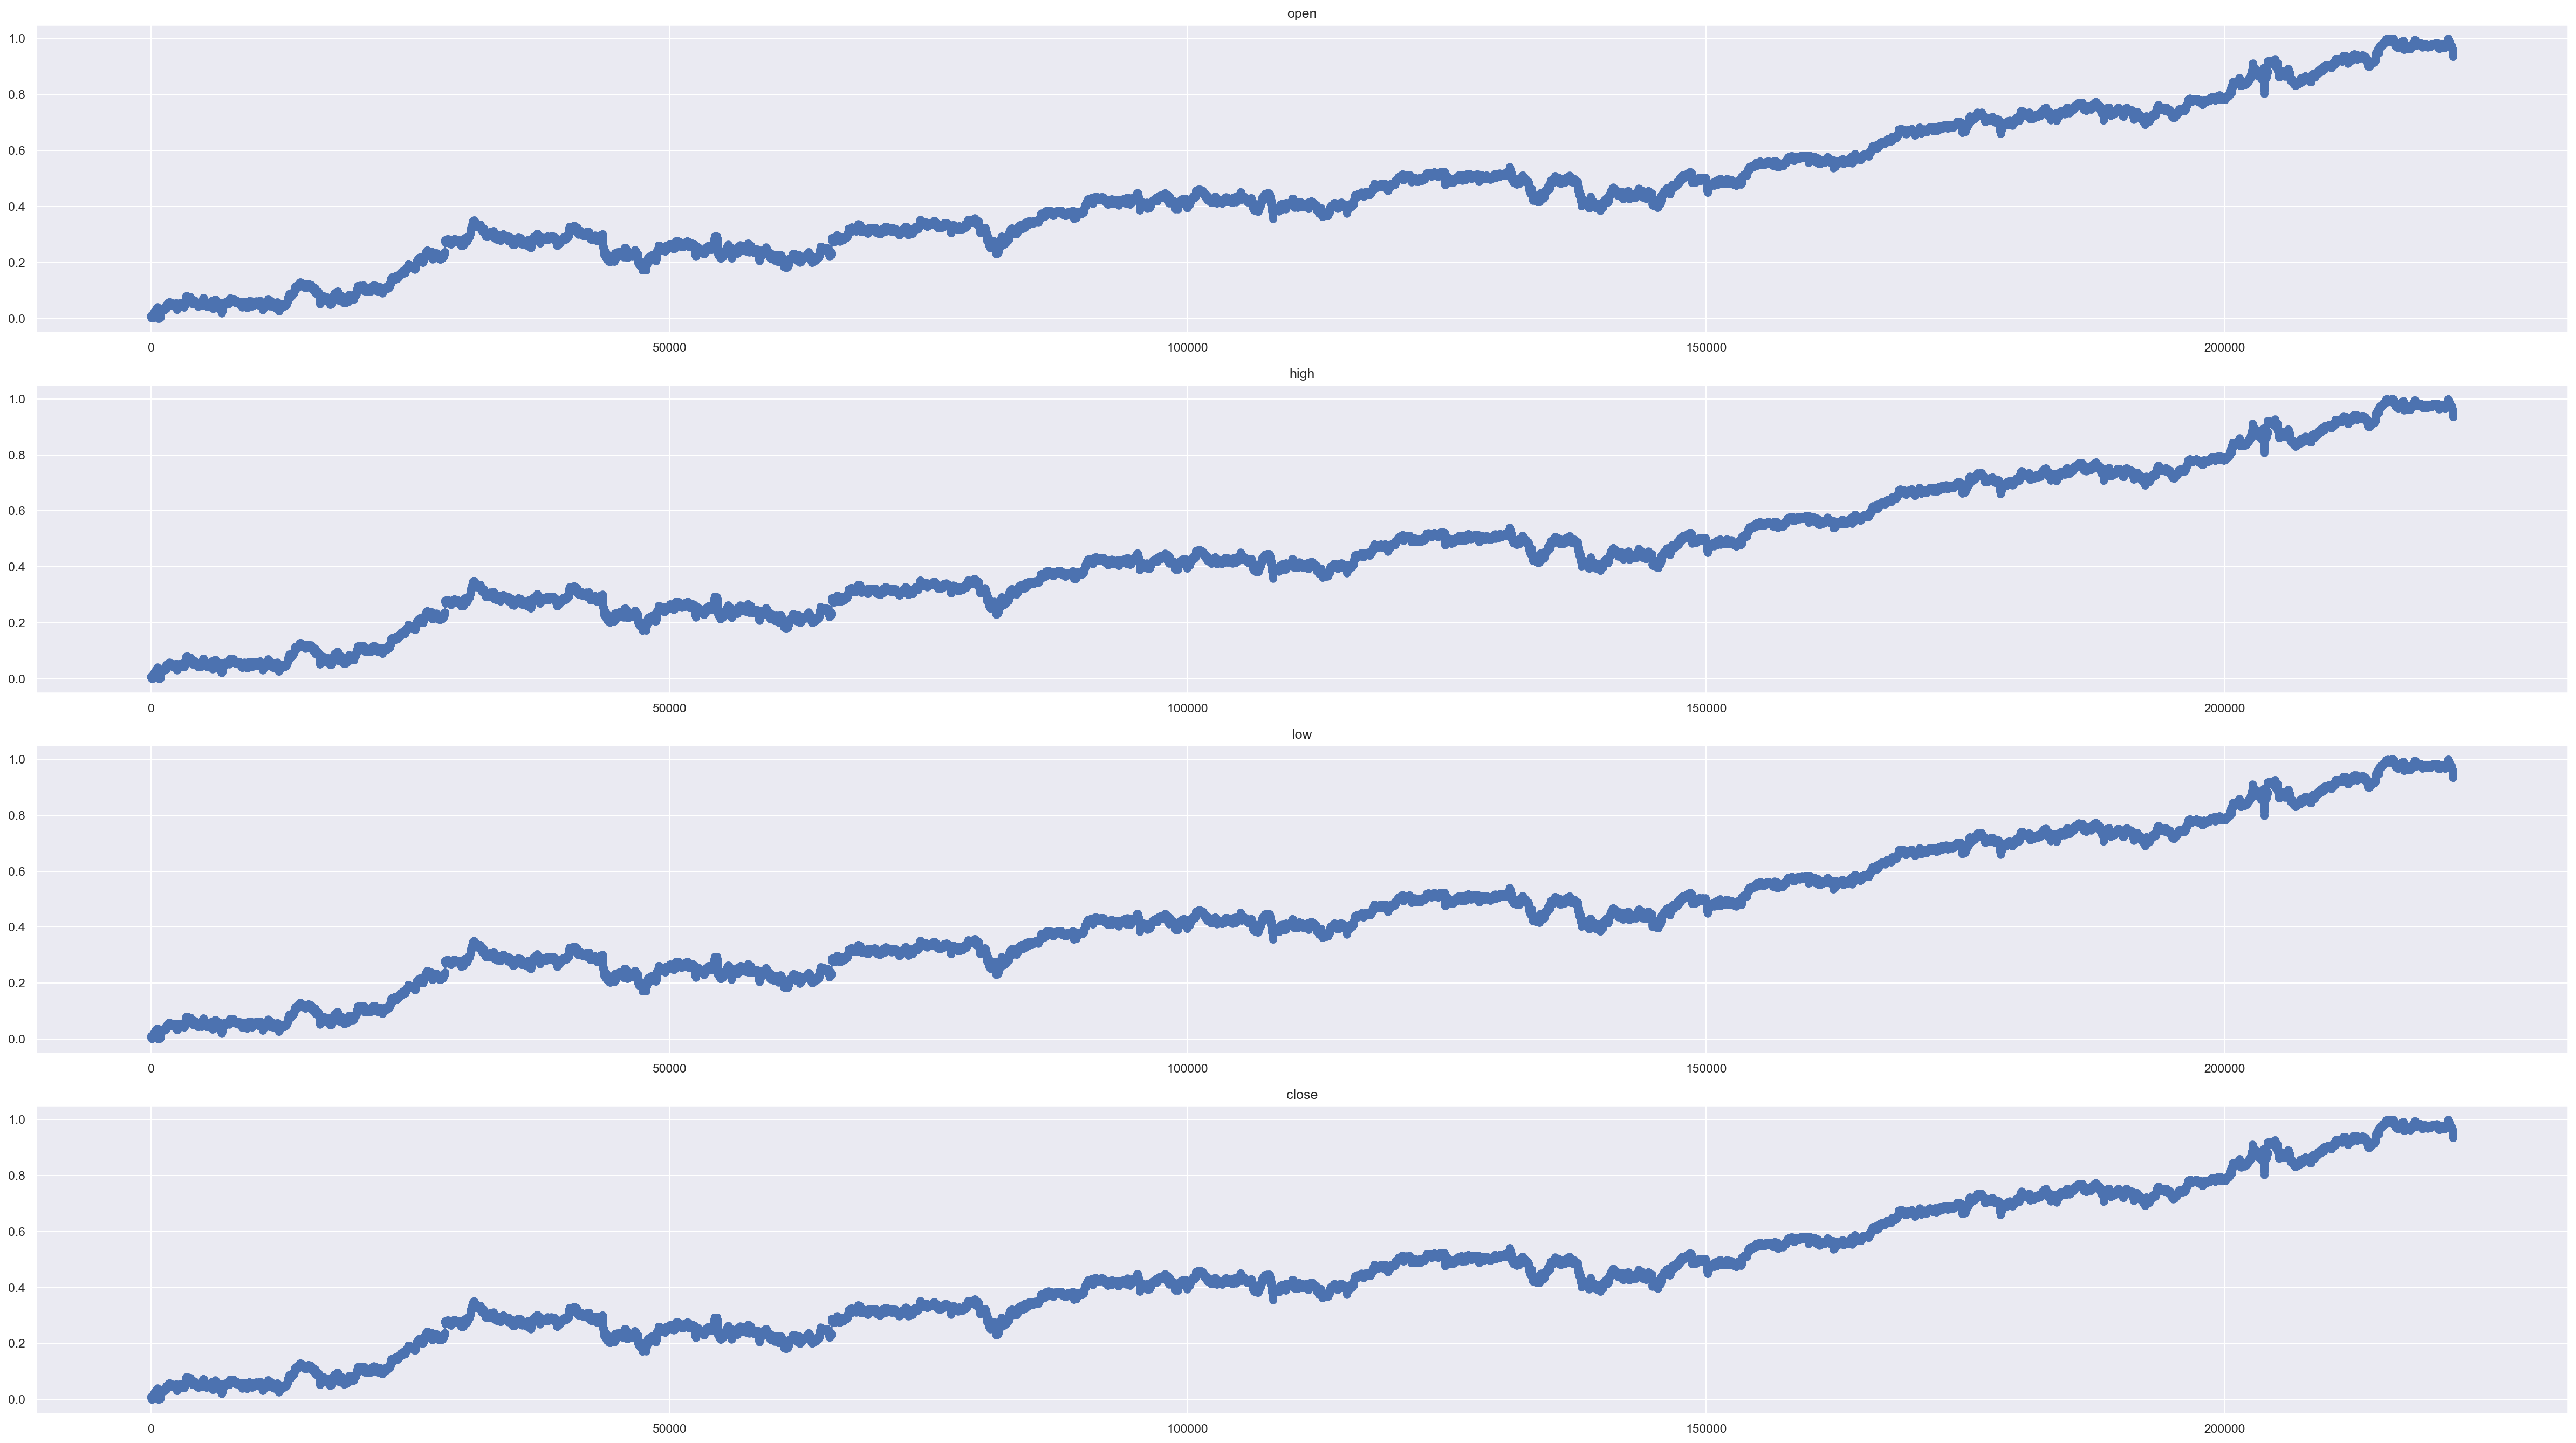

In [5]:
## 多维归一化
def NormalizeMult(data):
    normalize = np.arange(2 * data.shape[1], dtype='float64')
    normalize = normalize.reshape(data.shape[1], 2)
    for i in range(0, data.shape[1]):
        list = data[:, i]
        listlow, listhigh = np.percentile(list, [0, 100])
        normalize[i, 0] = listlow
        normalize[i, 1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            for j in range(0, data.shape[0]):
                data[j, i] = (data[j, i] - listlow) / delta
    return data, normalize

data_np = np.array(data)
data_normalized, normalize = NormalizeMult(data_np)
data_normalized = pd.DataFrame(data_normalized, columns=data.columns)

# 可视化
plt.figure(figsize=(32, 18), dpi=150)
for i, column in enumerate(data_normalized.columns):
    plt.subplot(4, 1, i + 1)
    plt.plot(data_normalized[column], linestyle='-', color='b', marker='o', markerfacecolor='b')
    plt.title(column)
plt.tight_layout()
plt.savefig(fname='变换后的数据概览.png')

print('数据形状：', data_normalized.shape)
print('-------------------------------------数据预处理已完成-------------------------------------')

## 三、模型建立

### 3.1 数据集划分与模型准备

In [6]:
####--------------------------------------3、建模建立--------------------------------------####
## 参数
SINGLE_ATTENTION_VECTOR = False
INPUT_DIMS = 4
TIME_STEPS = 30
lstm_units = 64
epoch = 10
dropout = 0.3
batch_size= 32

## 数据重塑
def create_dataset_tomorrow(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset.iloc[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back, :])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)
    return TrainX, Train_Y

X, Y = create_dataset_tomorrow(data_normalized, TIME_STEPS)

## 划分训练集80%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)

print('训练集特征形状：', X_train.shape)
print('训练集目标形状：', y_train.shape)
print('验证集特征形状：', X_val.shape)
print('验证集目标形状：', y_val.shape)
print('测试集特征形状：', X_test.shape)
print('测试集目标形状：', y_test.shape)

import numpy as np
from keras.models import Model
from keras.layers import Input, Conv1D, Dropout, Bidirectional, LSTM, Flatten, Dense, Lambda, RepeatVector, Permute, Multiply
import keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.callbacks import EarlyStopping 
from keras.regularizers import l1, l2

## Attention层
def attention_3d_block(inputs):
    input_dim = int(inputs.shape[2])
    a = inputs
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

训练集特征形状： (133197, 30, 4)
训练集目标形状： (133197, 4)
验证集特征形状： (44399, 30, 4)
验证集目标形状： (44399, 4)
测试集特征形状： (44400, 30, 4)
测试集目标形状： (44400, 4)


### 3.2 CNN-BiLSTM-Attention模型
#### 3.2.1 模型结构

In [7]:
## CNN-BiLSTM-Attention模型
def attention_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))

    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)  
    x = Dropout(dropout)(x)

    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(dropout)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)

    output = Dense(4, activation='linear')(attention_mul) 
    model = Model(inputs=[inputs], outputs=output)
    return model

m1 = attention_model()

# 输出模型结构
print(m1.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 4)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 30, 64)               320       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 30, 64)               0         ['conv1d[0][0]']              
                                                                                                  
 bidirectional (Bidirection  (None, 30, 128)              66048     ['dropout[0][0]']             
 al)                                                                                          

#### 3.2.2 训练模型

Epoch 1/10
4163/4163 [==============================] - 47s 11ms/step - loss: 0.0015 - val_loss: 2.0187e-04
Epoch 2/10
4163/4163 [==============================] - 41s 10ms/step - loss: 9.5143e-05 - val_loss: 2.3468e-04
Epoch 3/10
4163/4163 [==============================] - 38s 9ms/step - loss: 6.3533e-05 - val_loss: 2.4447e-04
Epoch 4/10
4163/4163 [==============================] - 37s 9ms/step - loss: 5.0847e-05 - val_loss: 8.5589e-05
Epoch 5/10
4163/4163 [==============================] - 37s 9ms/step - loss: 4.1828e-05 - val_loss: 1.6299e-04
Epoch 6/10
4163/4163 [==============================] - 37s 9ms/step - loss: 3.7719e-05 - val_loss: 1.2802e-04
Epoch 7/10
4163/4163 [==============================] - 38s 9ms/step - loss: 3.4369e-05 - val_loss: 1.2328e-04


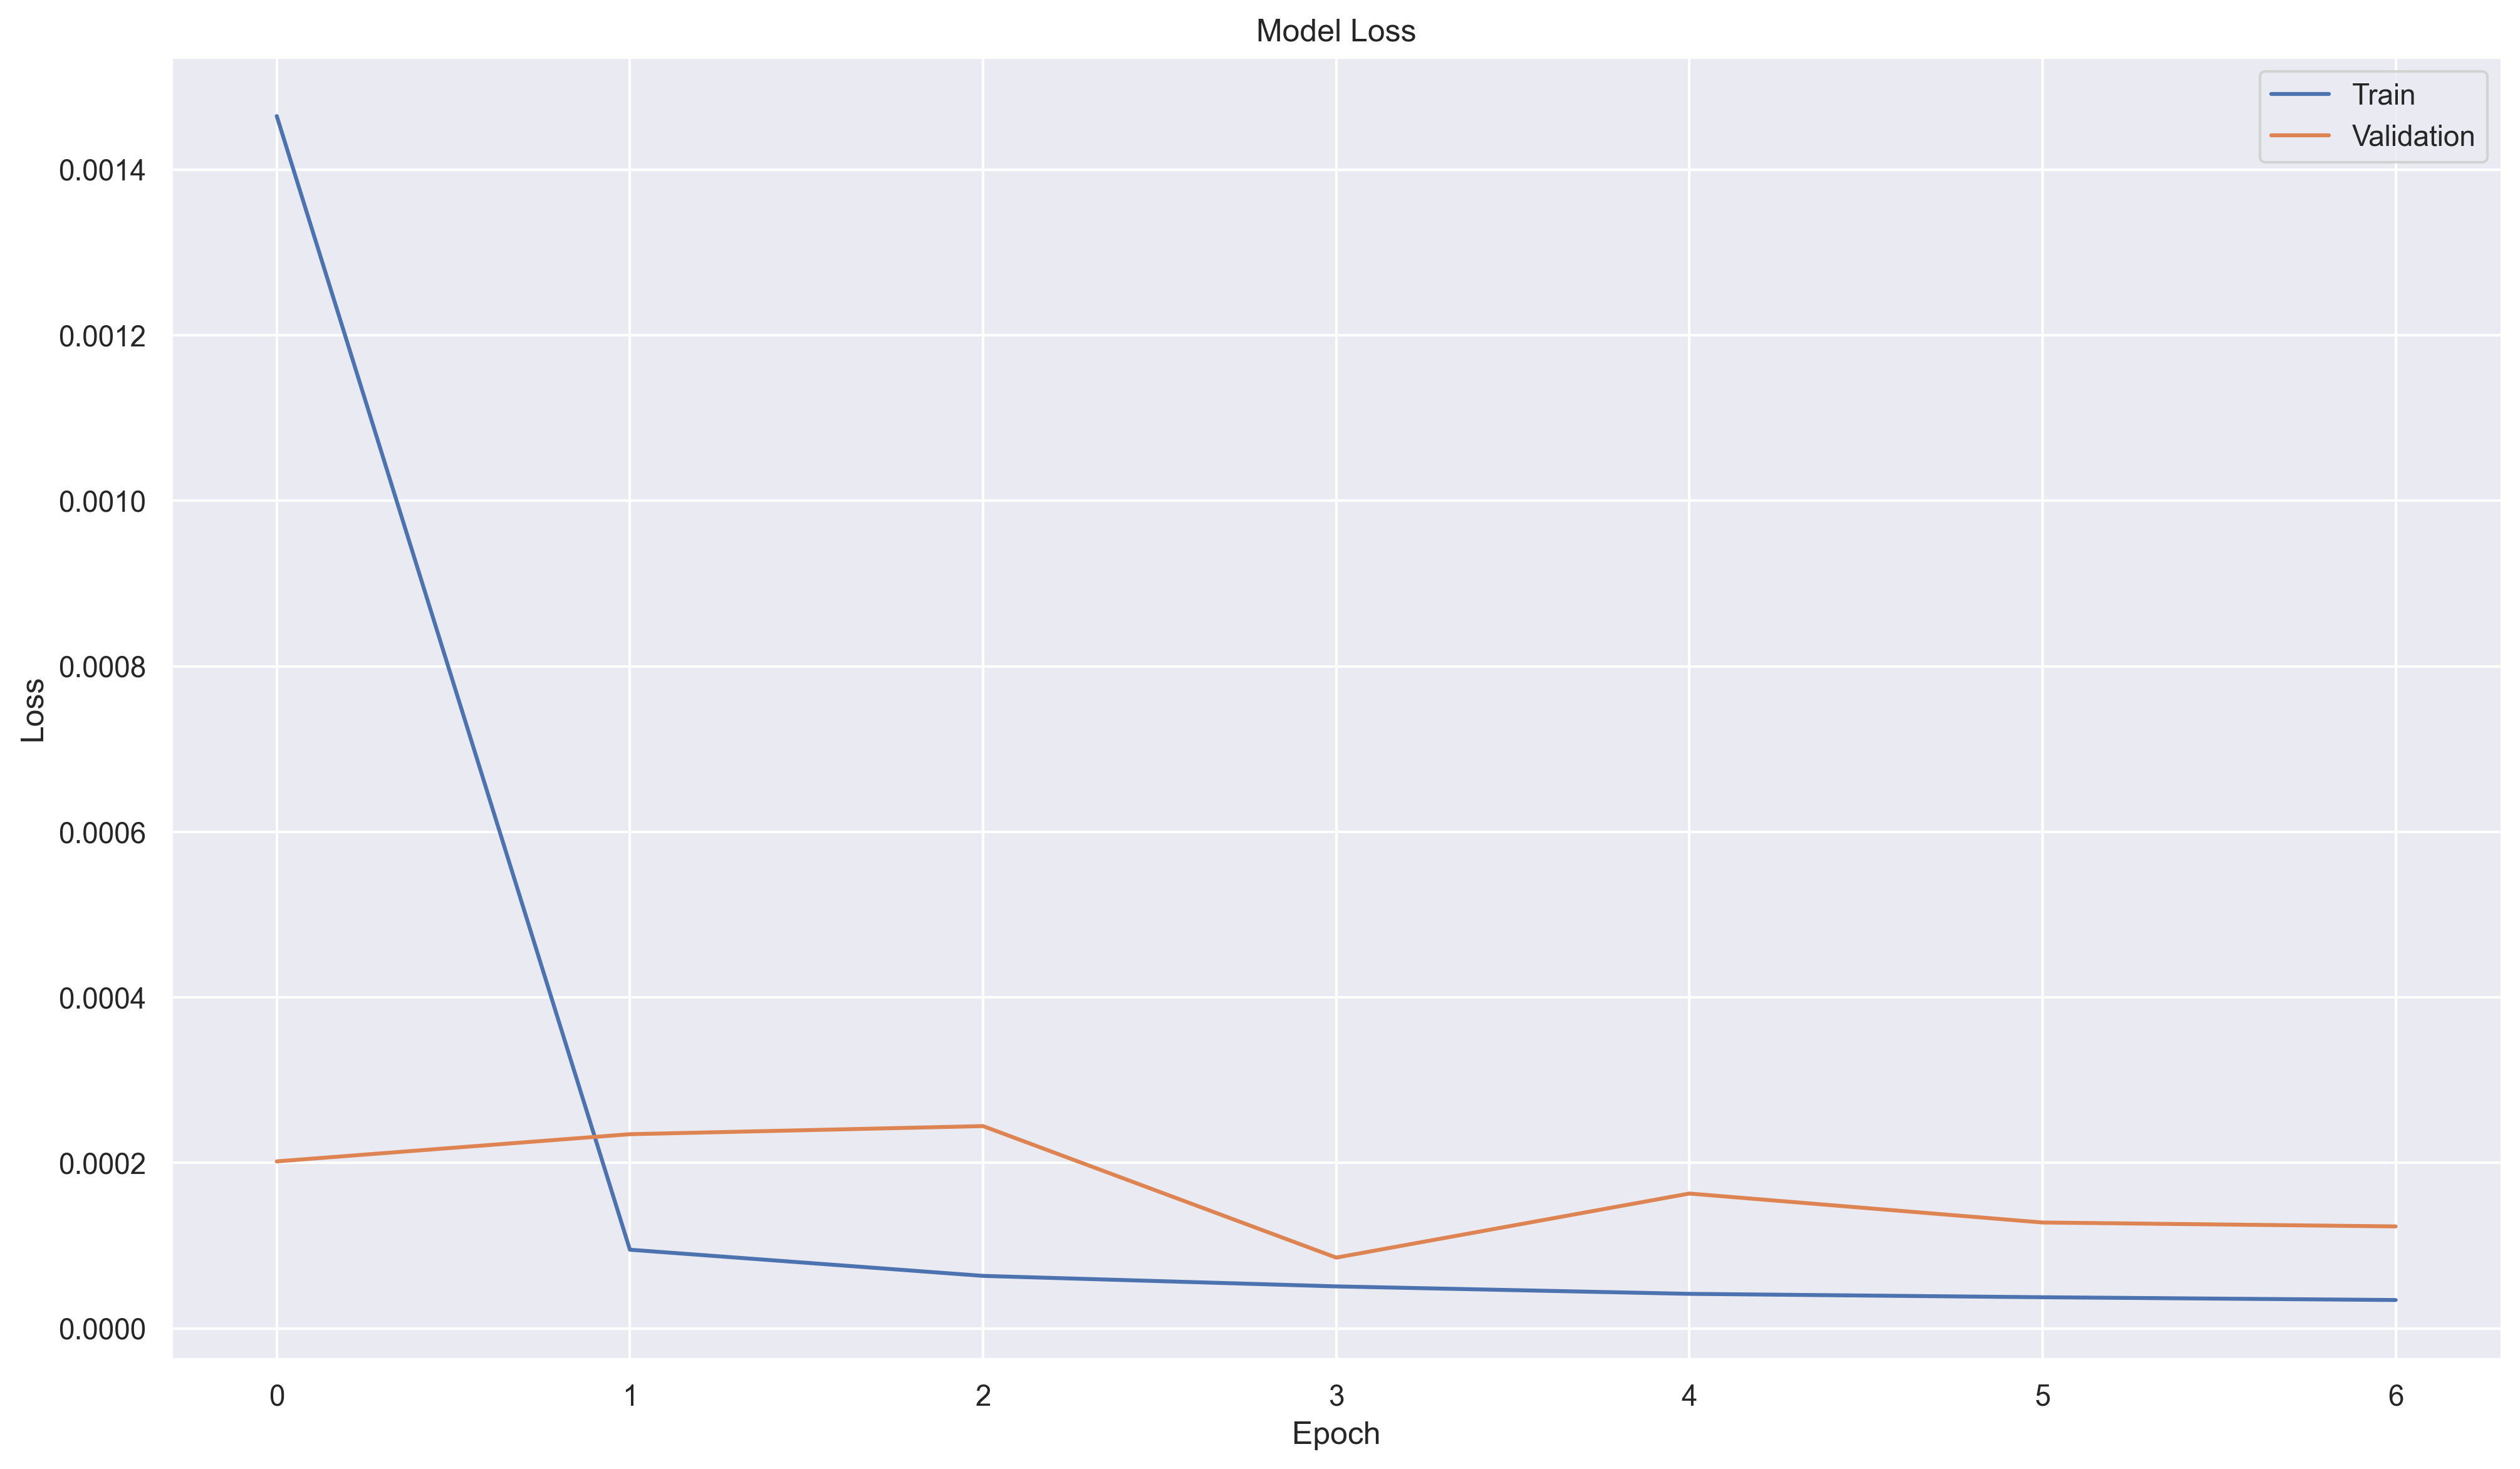

In [8]:
# 编译模型，选择合适的优化器和损失函数
m1.compile(optimizer='adam', loss='mse')

# 训练模型
# 早停法--验证集损失连续 3 个 epoch 没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = m1.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])

# 绘制训练和验证损失曲线
plt.figure(figsize=(16, 9), dpi=300)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig(fname='损失曲线.png')

#### 3.2.3 模型评估

In [9]:
# 在测试集上评估模型
y_pred_test = m1.predict(X_test)
mse_test_LSTM = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_LSTM)
rmse_test_LSTM = np.sqrt(mse_test_LSTM)
print('测试集RMSE:', rmse_test_LSTM)
mae_test_LSTM = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_LSTM)
mape_test_LSTM = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_LSTM)
r2_test_LSTM = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_LSTM)

1388/1388 [==============================] - 4s 2ms/step
测试集MSE: 8.655906282443318e-05
测试集RMSE: 0.009303712314148217
测试集MAE: 0.006147014501345888
测试集MAPE: 391925212.40870565
测试集R2: 0.9985395892533611


#### 3.2.4 拟合情况

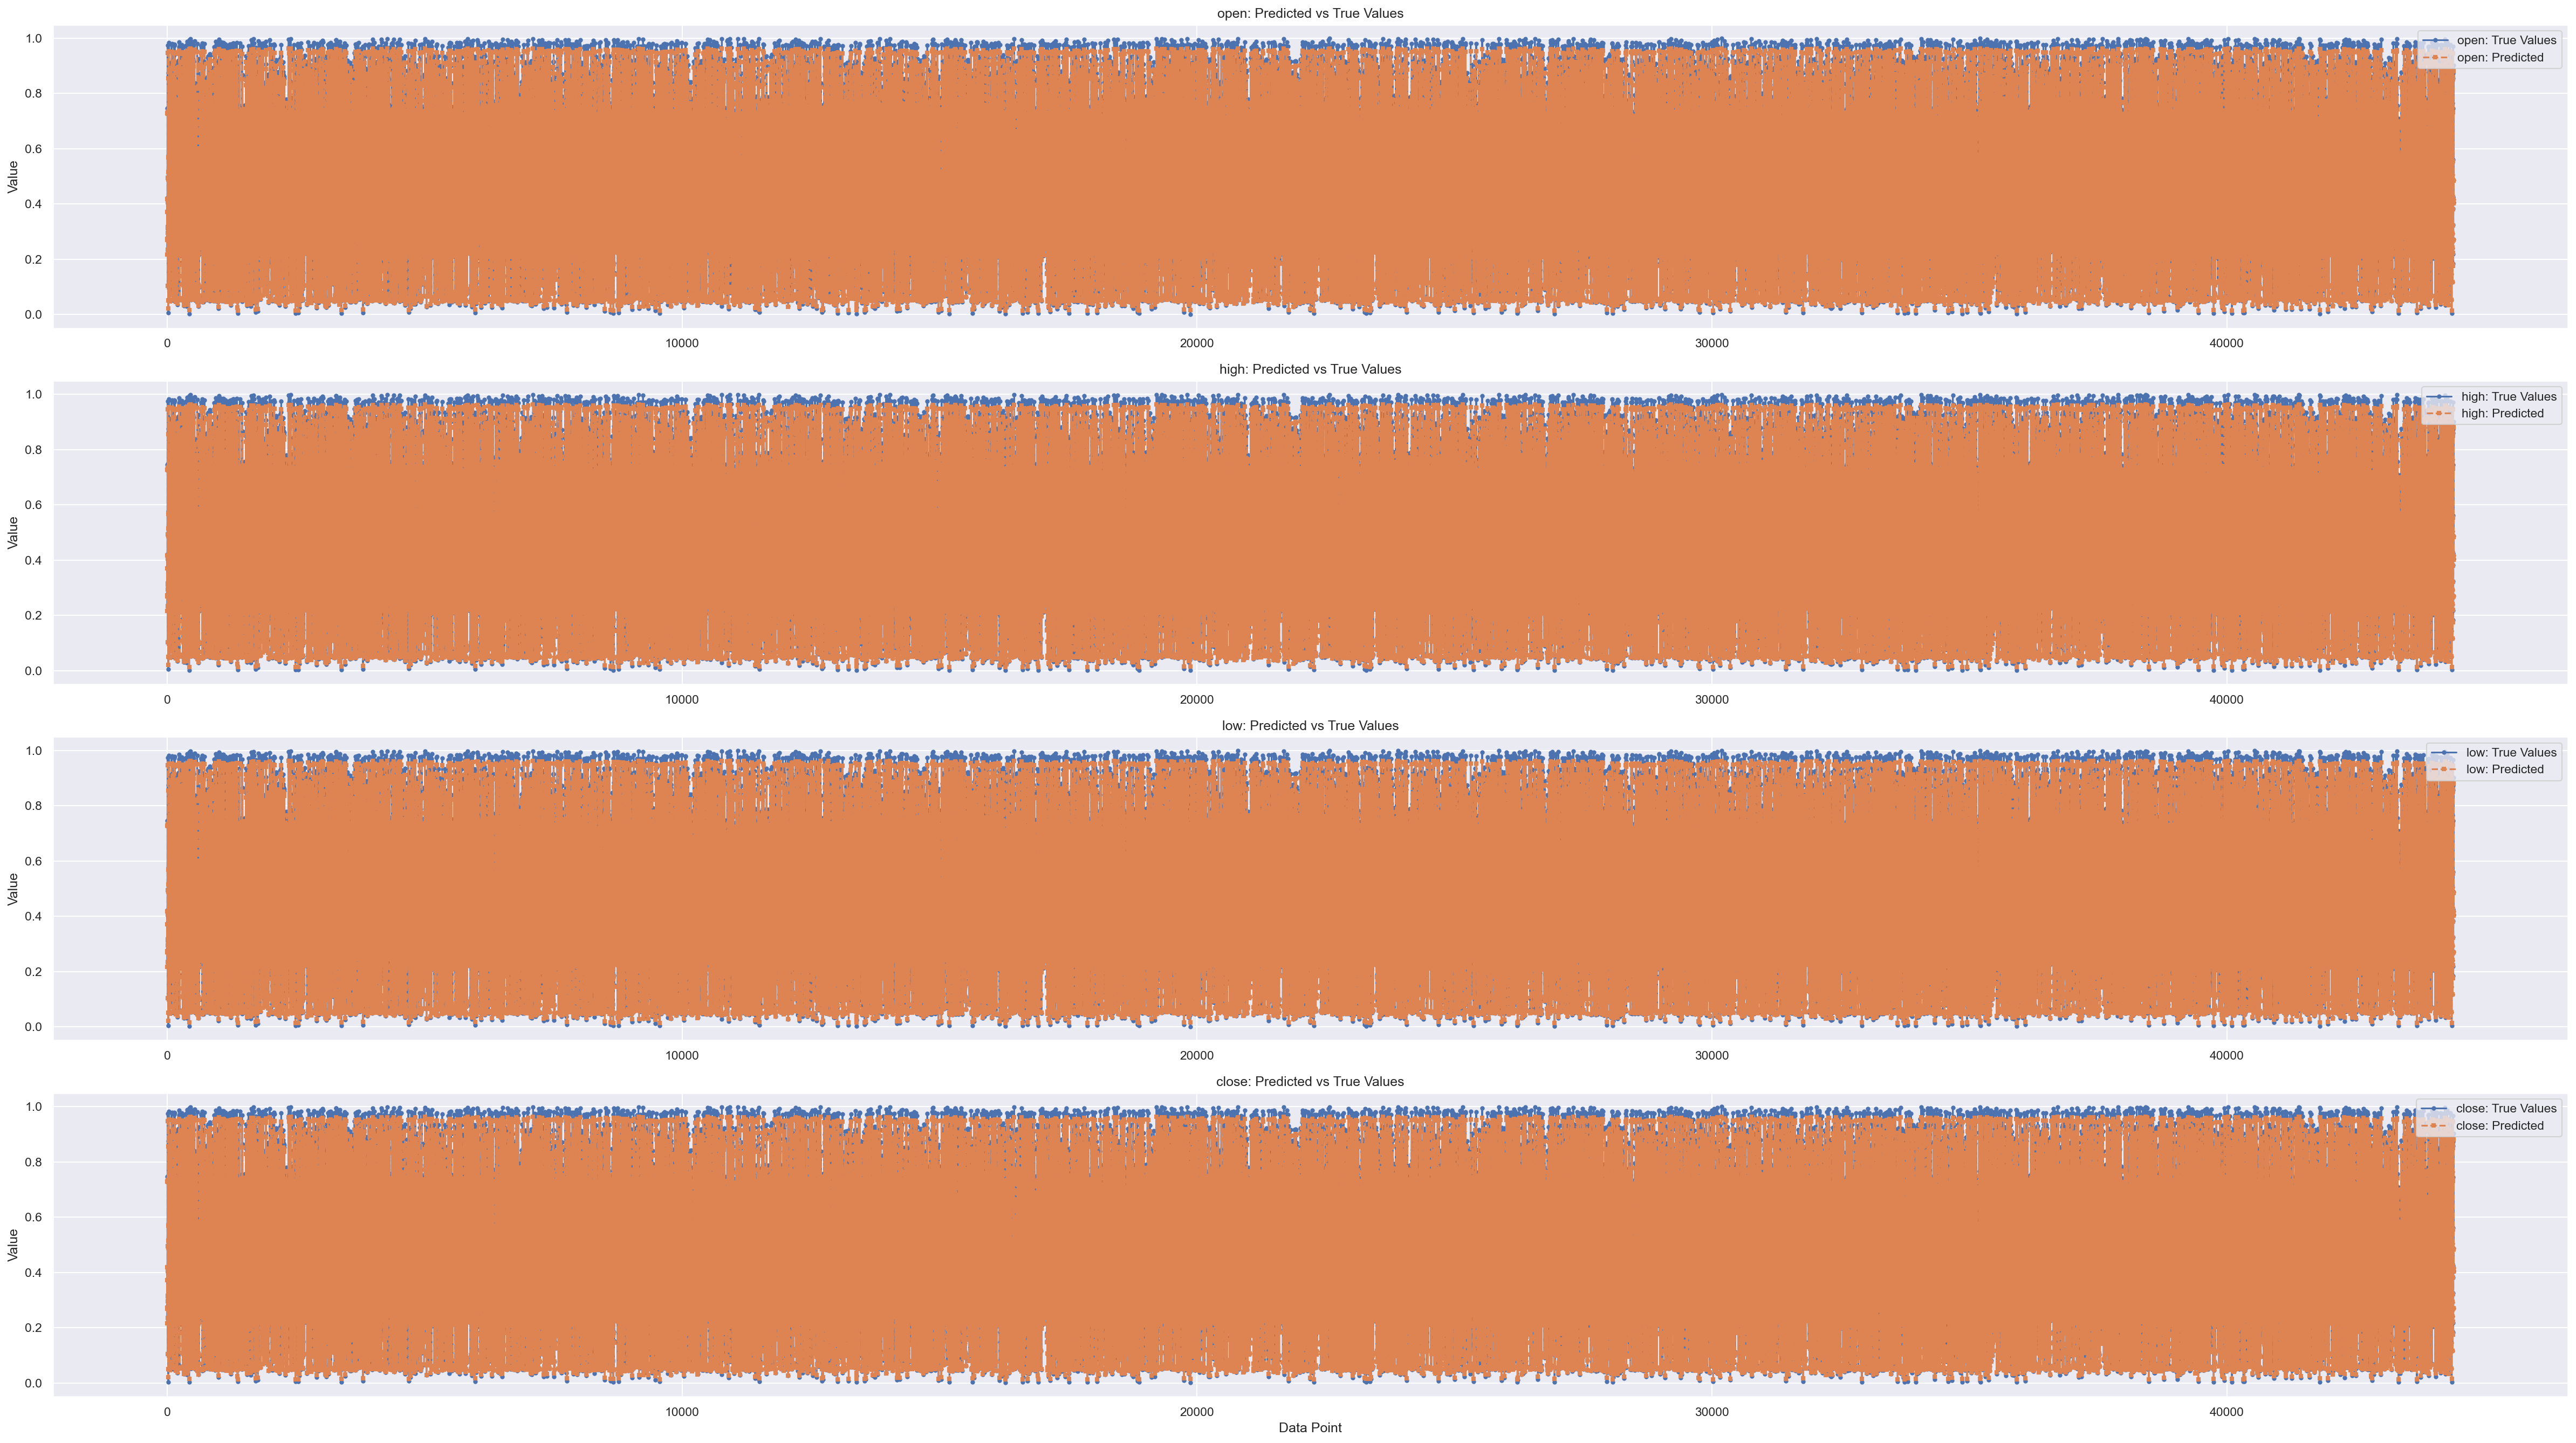

In [10]:
# 拟合情况
num_features = y_test.shape[1]
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(32, 18), dpi=150)
feature_names = ['open', 'high', 'low', 'close']

for i in range(num_features):
    axes[i].plot(y_test[:, i], label=f'{feature_names[i]}: True Values', linestyle='-', marker='o', markersize=3)

    axes[i].plot(y_pred_test[:, i], label=f'{feature_names[i]}: Predicted', linestyle='--', marker='s', markersize=3)

    axes[i].set_title(f'{feature_names[i]}: Predicted vs True Values')
    axes[i].set_ylabel('Value')
    if i == num_features - 1:
        axes[i].set_xlabel('Data Point')
    axes[i].legend()

plt.tight_layout()
plt.savefig(fname='预测值与真实值拟合情况.png')

#### 3.2.5 部分数据
上图数据量太大，现展示前100个数据

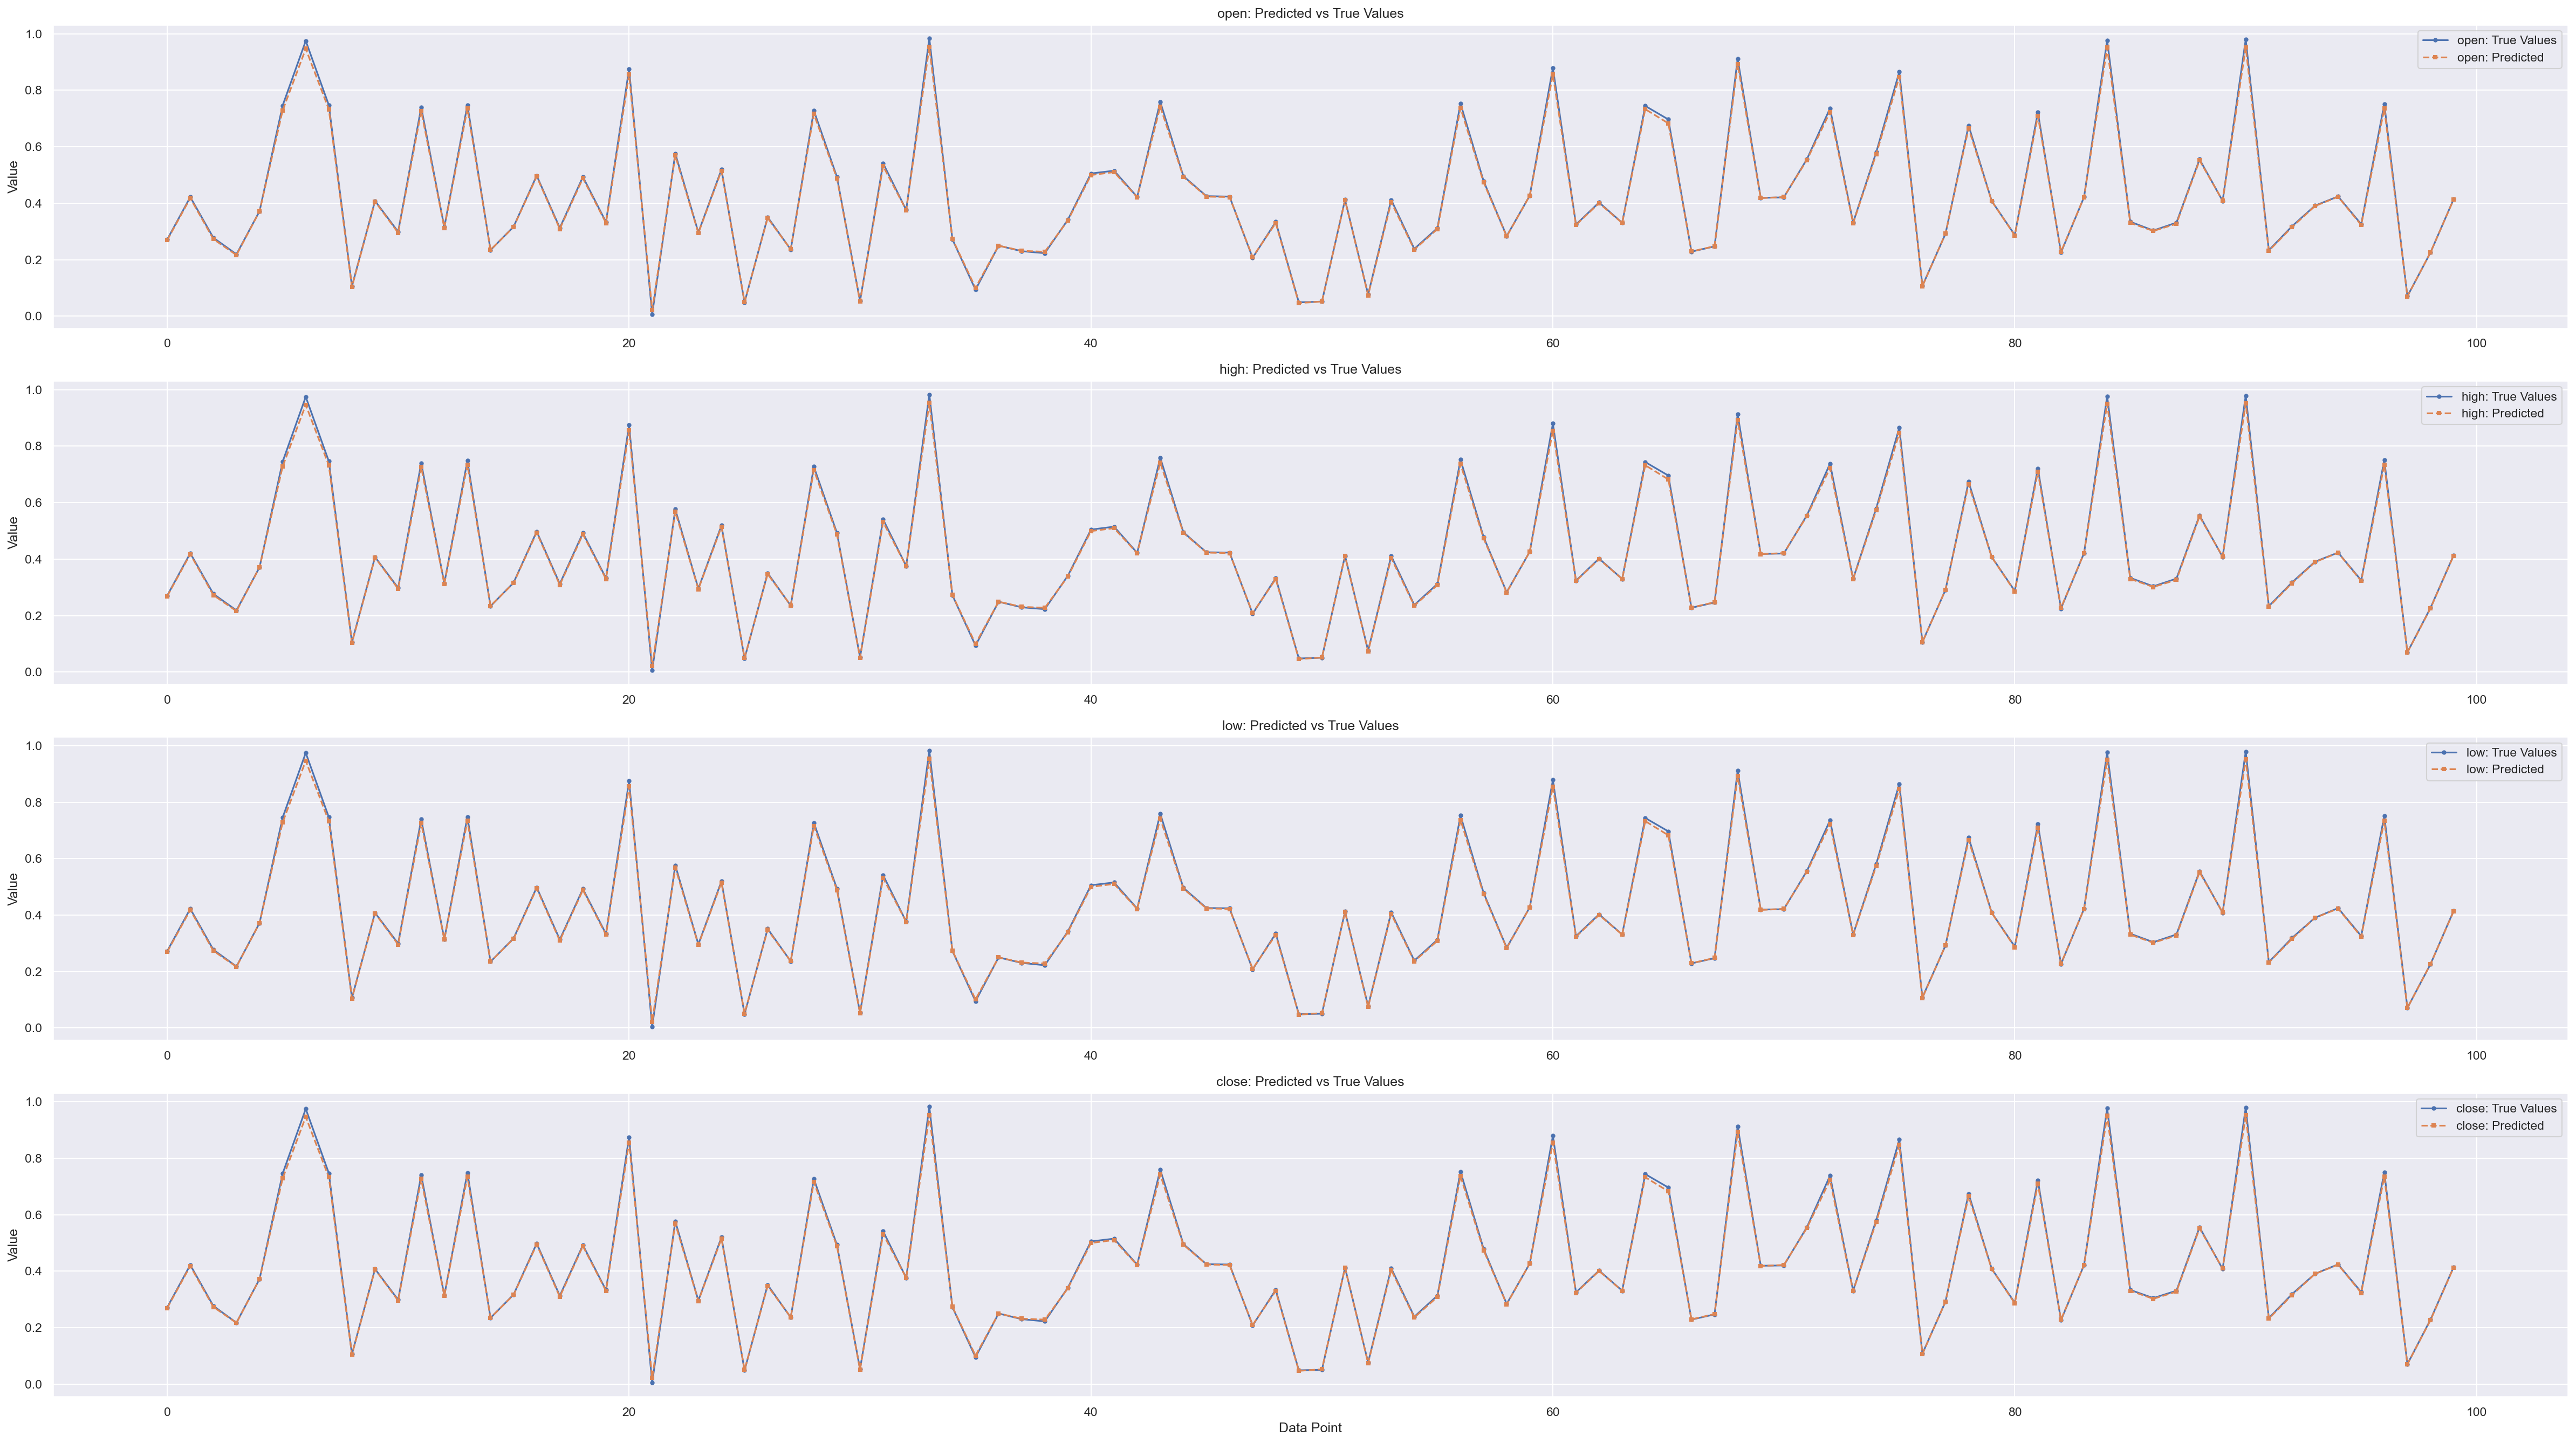

In [11]:
## 部分数据
num_features = y_test.shape[1]
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(32, 18), dpi=150)
feature_names = ['open', 'high', 'low', 'close']

num_data_points_to_show = 100

for i in range(num_features):
    axes[i].plot(y_test[:num_data_points_to_show, i], label=f'{feature_names[i]}: True Values', linestyle='-', marker='o', markersize=3)
    axes[i].plot(y_pred_test[:num_data_points_to_show, i], label=f'{feature_names[i]}: Predicted', linestyle='--', marker='s', markersize=3)

    axes[i].set_title(f'{feature_names[i]}: Predicted vs True Values')
    axes[i].set_ylabel('Value')
    if i == num_features - 1:
        axes[i].set_xlabel('Data Point')
    axes[i].legend()

plt.tight_layout()
plt.savefig(fname='前一百个数据情况.png')

### 3.3 CNN-BiGRU-Attention模型
#### 3.3.1 模型结构

In [12]:
####--------------------------------------4、模型对比--------------------------------------####
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv1D, Dropout, Bidirectional, GRU, Flatten, Dense, Lambda, RepeatVector, Permute, Multiply
import keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.callbacks import EarlyStopping 
from keras.regularizers import l1, l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 参数
SINGLE_ATTENTION_VECTOR = False
INPUT_DIMS = 4
TIME_STEPS = 30
gru_units = 64
epoch = 10
dropout = 0.3
batch_size = 64

# 数据重塑
def create_dataset_tomorrow(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset.iloc[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back, :])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)
    return TrainX, Train_Y

X, Y = create_dataset_tomorrow(data_normalized, TIME_STEPS)

# 划分训练集80%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)

print('训练集特征形状：', X_train.shape)
print('训练集目标形状：', y_train.shape)
print('验证集特征形状：', X_val.shape)
print('验证集目标形状：', y_val.shape)
print('测试集特征形状：', X_test.shape)
print('测试集目标形状：', y_test.shape)

## Attention层
def attention_3d_block(inputs):
    input_dim = int(inputs.shape[2])
    a = inputs
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

## CNN-BiGRU-Attention模型
def attention_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))

    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)  
    x = Dropout(dropout)(x)

    gru_out = Bidirectional(GRU(gru_units, return_sequences=True))(x)
    gru_out = Dropout(dropout)(gru_out)
    attention_mul = attention_3d_block(gru_out)
    attention_mul = Flatten()(attention_mul)

    output = Dense(4, activation='linear')(attention_mul) 
    model = Model(inputs=[inputs], outputs=output)
    return model

m2 = attention_model()

# 输出模型结构
print(m2.summary())

训练集特征形状： (133197, 30, 4)
训练集目标形状： (133197, 4)
验证集特征形状： (44399, 30, 4)
验证集目标形状： (44399, 4)
测试集特征形状： (44400, 30, 4)
测试集目标形状： (44400, 4)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 4)]              0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 30, 64)               320       ['input_2[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 30, 64)               0         ['conv1d_1[0][0]']            
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 30, 128)             

#### 3.3.2 训练模型

Epoch 1/10
2082/2082 [==============================] - 27s 13ms/step - loss: 0.0025 - val_loss: 2.6830e-04
Epoch 2/10
2082/2082 [==============================] - 26s 12ms/step - loss: 1.3216e-04 - val_loss: 3.2272e-04
Epoch 3/10
2082/2082 [==============================] - 26s 13ms/step - loss: 9.3659e-05 - val_loss: 0.0012
Epoch 4/10
2082/2082 [==============================] - 26s 12ms/step - loss: 7.4055e-05 - val_loss: 0.0013


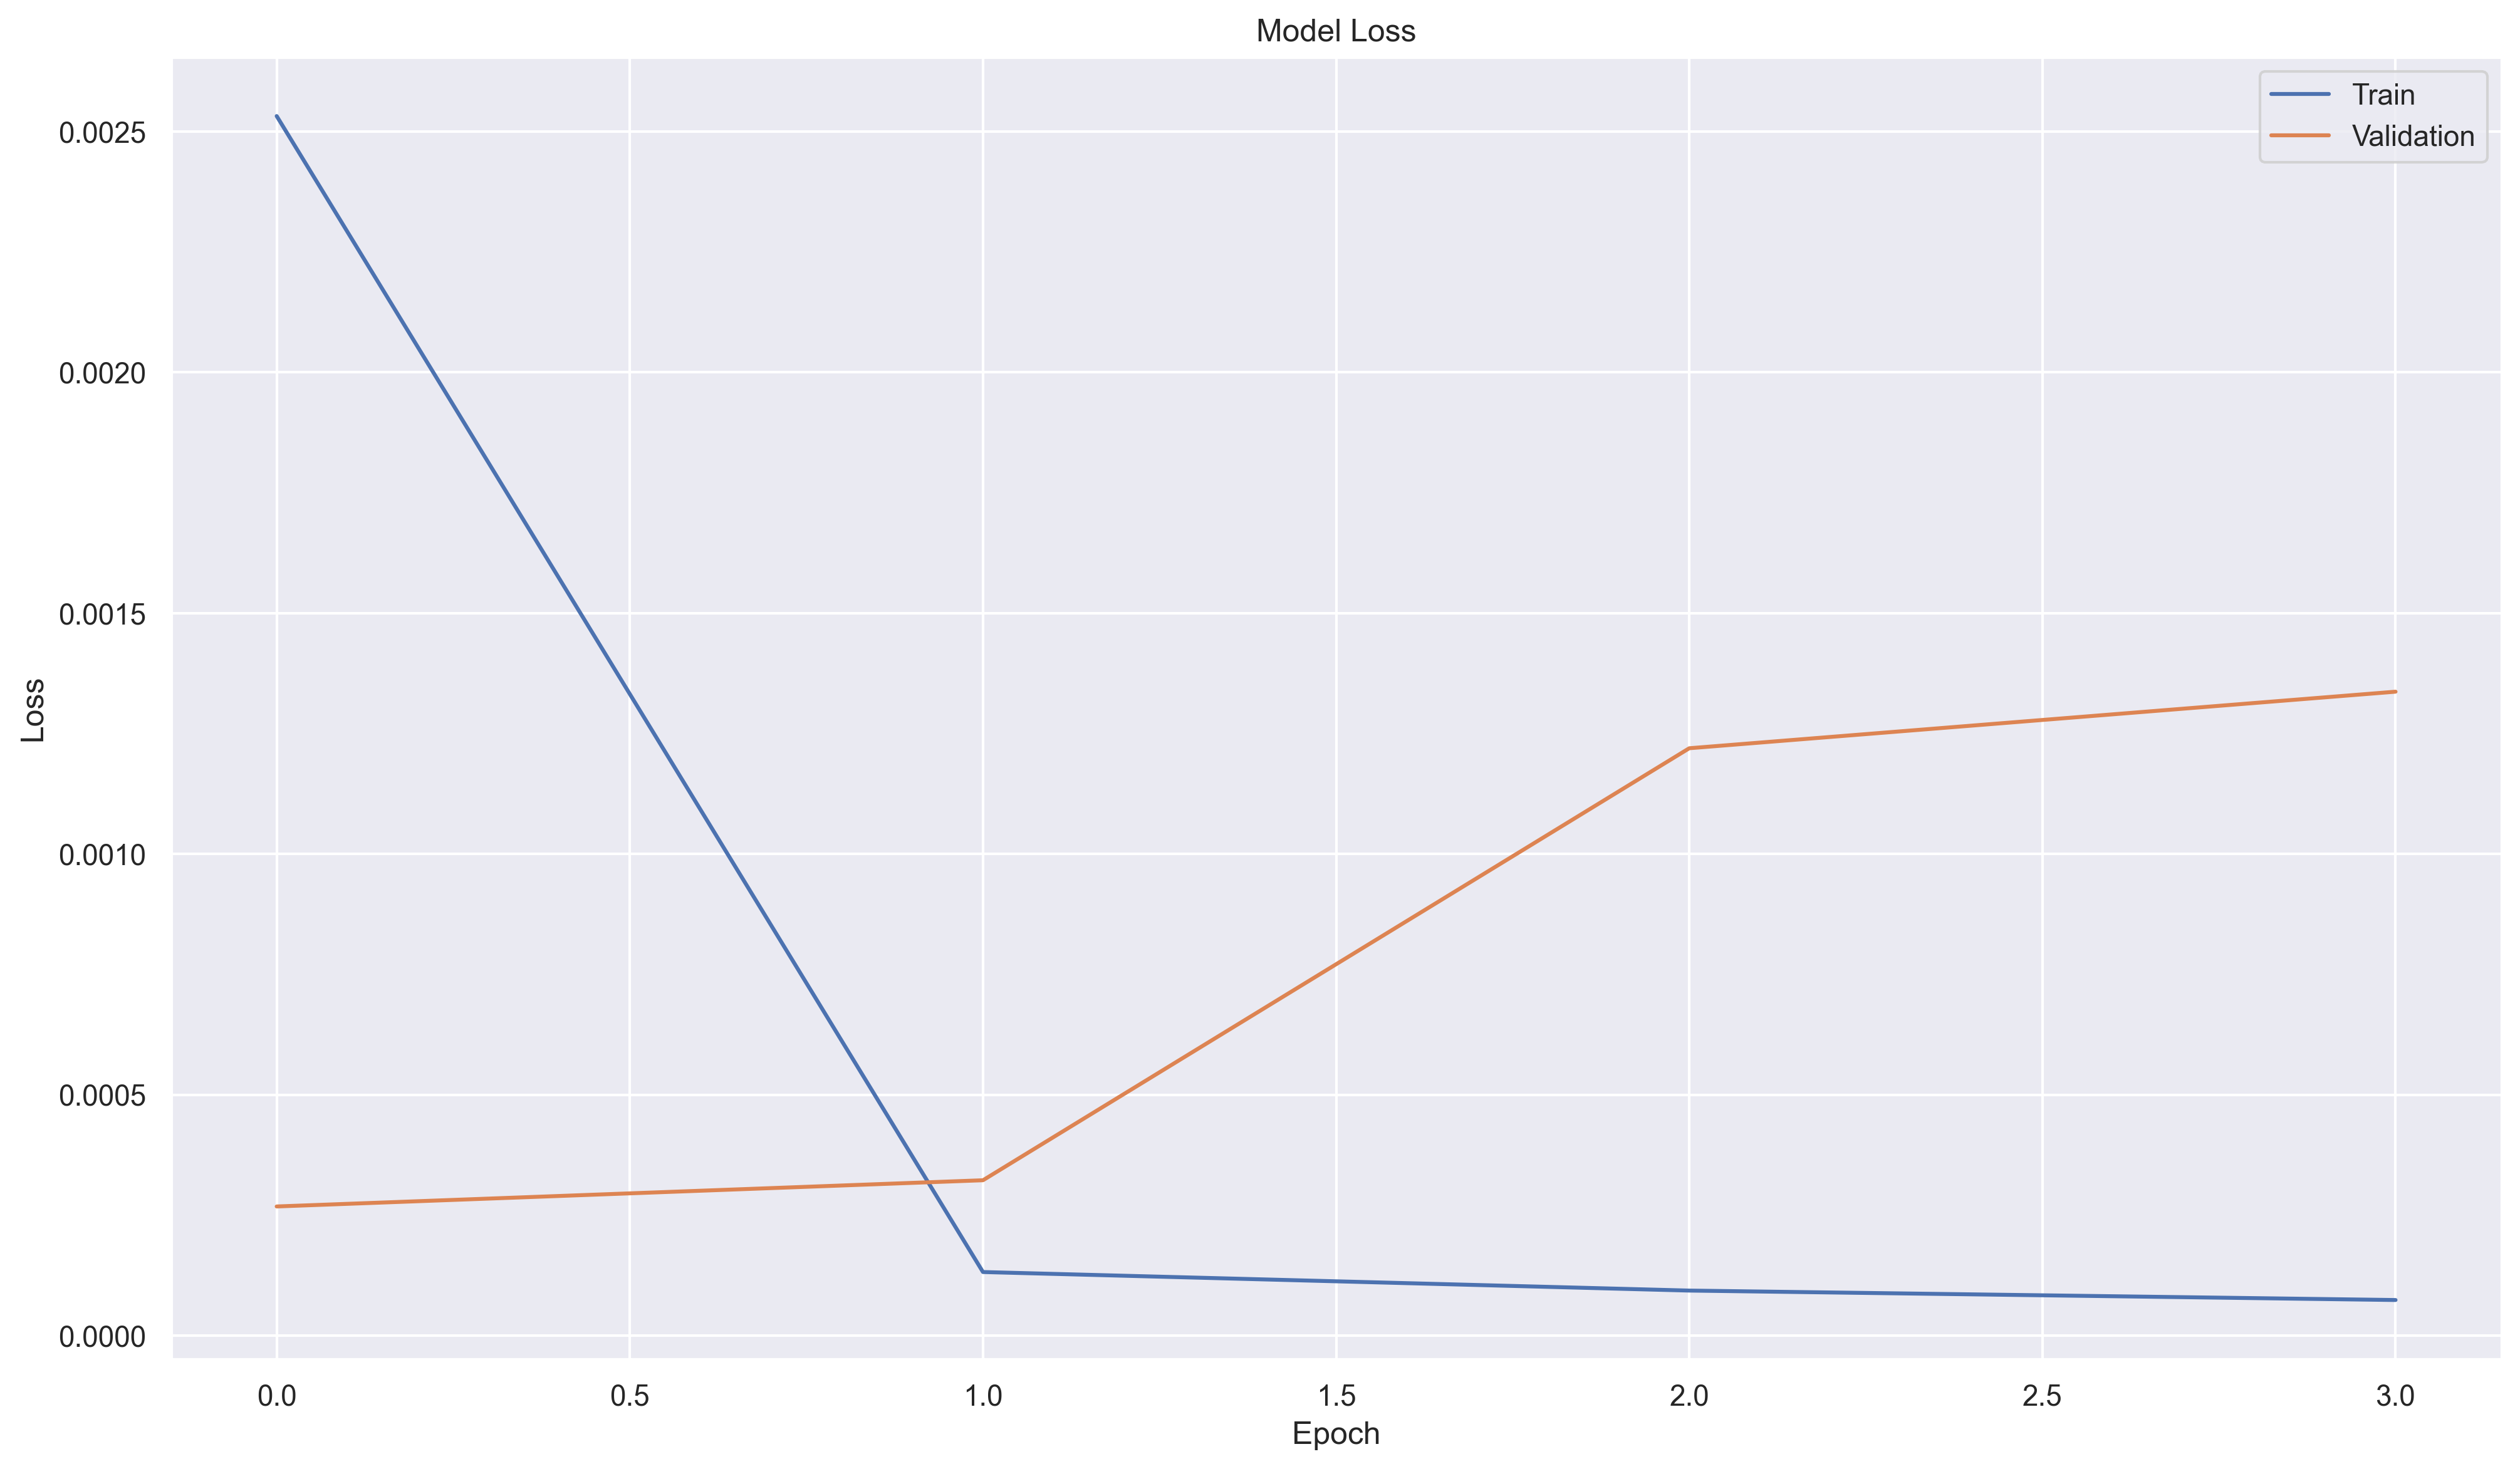

In [13]:
# 编译模型，选择合适的优化器和损失函数
m2.compile(optimizer='adam', loss='mse')

# 训练模型
# 早停法--验证集损失连续3个epoch没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = m2.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])

# 绘制训练和验证损失曲线
plt.figure(figsize=(16, 9), dpi=300)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig(fname='CNN-BiGRU-Attention损失曲线.png')

#### 3.3.3 模型评估

In [14]:
# 在测试集上评估模型
y_pred_test = m2.predict(X_test)
mse_test_GRU = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_GRU)
rmse_test_GRU = np.sqrt(mse_test_GRU)
print('测试集RMSE:', rmse_test_GRU)
mae_test_GRU = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_GRU)
mape_test_GRU = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_GRU)
r2_test_GRU = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_GRU)


1388/1388 [==============================] - 3s 2ms/step
测试集MSE: 0.00026704004632002883
测试集RMSE: 0.01634135998991604
测试集MAE: 0.012078612241949605
测试集MAPE: 0.03468547065054715
测试集R2: 0.9954732586690953


#### 3.3.4 拟合情况

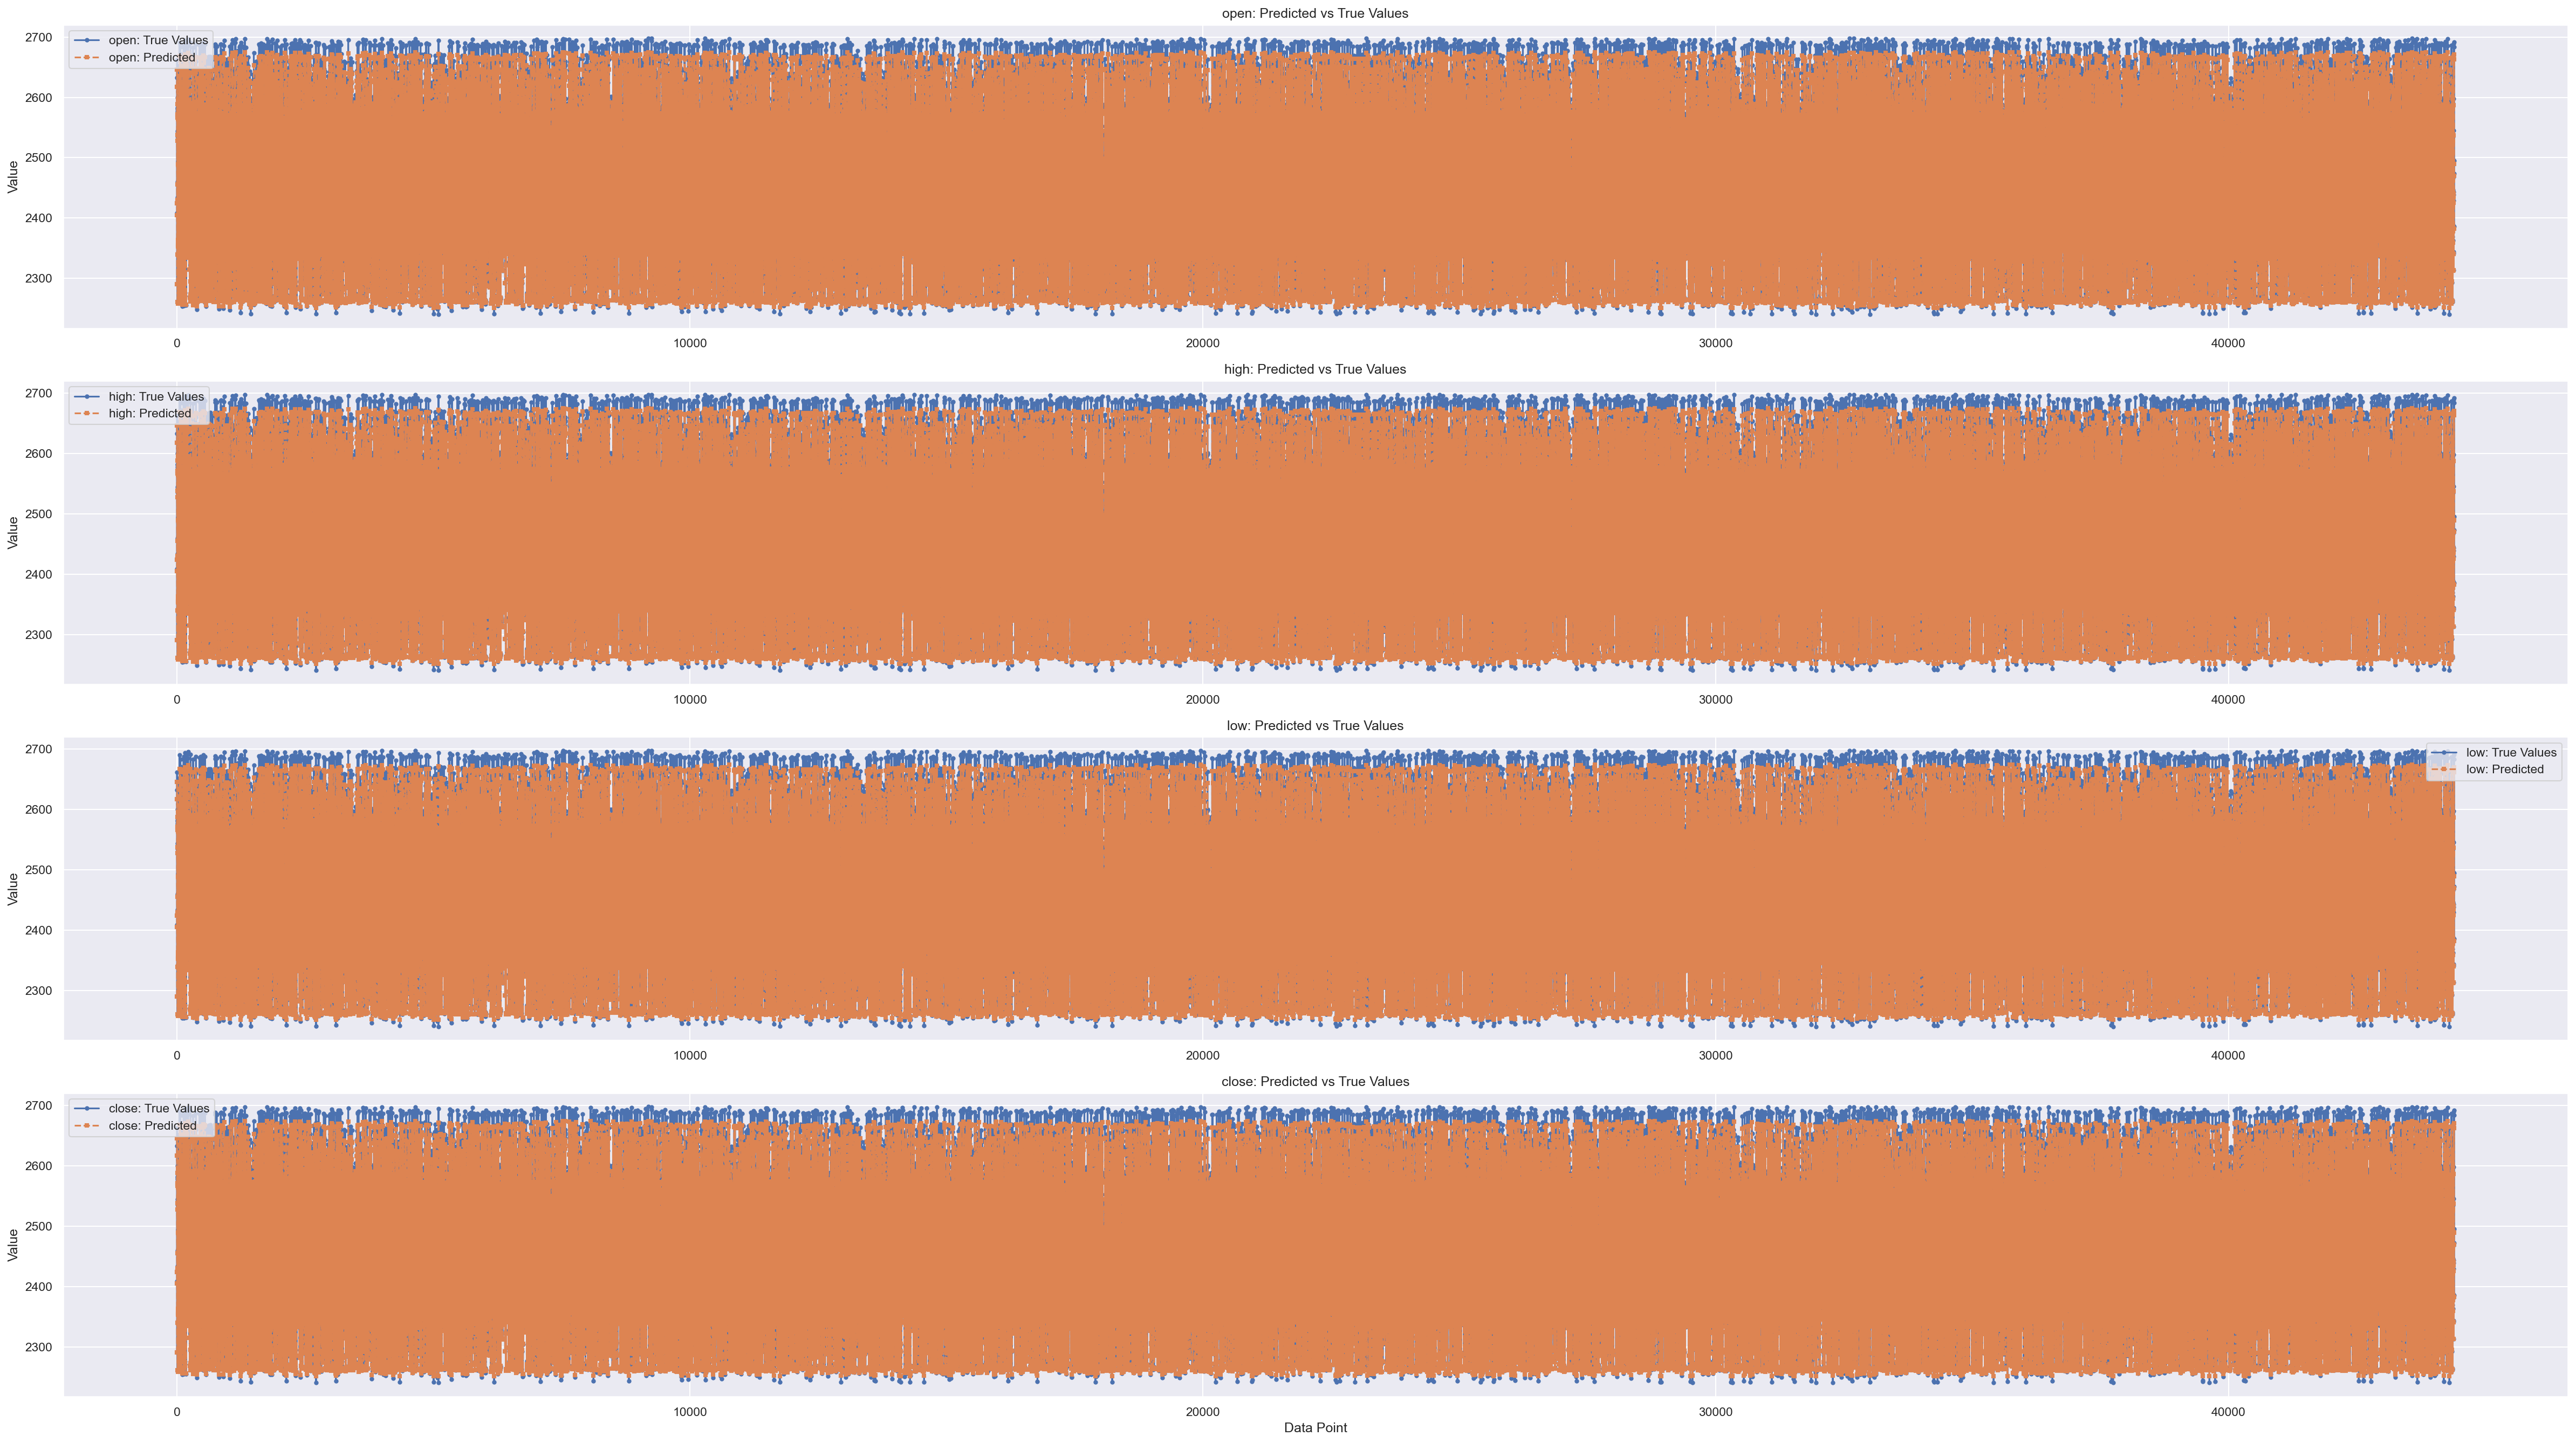

In [15]:
# 多维反归一化
def FNormalizeMult(data, normalize):
    data = np.array(data)
    for i in range(0, data.shape[1]):
        listlow = normalize[i, 0]
        listhigh = normalize[i, 1]
        delta = listhigh - listlow
        if delta!= 0:
            for j in range(0, data.shape[0]):
                data[j, i] = data[j, i] * delta + listlow

    return data

y_pred_test = FNormalizeMult(y_pred_test, normalize)
y_test = FNormalizeMult(y_test, normalize)

# 拟合情况
num_features = y_test.shape[1]
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(32, 18), dpi=150)
feature_names = ['open', 'high', 'low', 'close']

for i in range(num_features):
    axes[i].plot(y_test[:, i], label=f'{feature_names[i]}: True Values', linestyle='-', marker='o', markersize=3)

    axes[i].plot(y_pred_test[:, i], label=f'{feature_names[i]}: Predicted', linestyle='--', marker='s', markersize=3)

    axes[i].set_title(f'{feature_names[i]}: Predicted vs True Values')
    axes[i].set_ylabel('Value')
    if i == num_features - 1:
        axes[i].set_xlabel('Data Point')
    axes[i].legend()

plt.tight_layout()
plt.savefig(fname='CNN-BiGRU-Attention预测值与真实值拟合情况.png')

#### 3.2.5 部分数据
上图数据量太大，现展示前100个数据

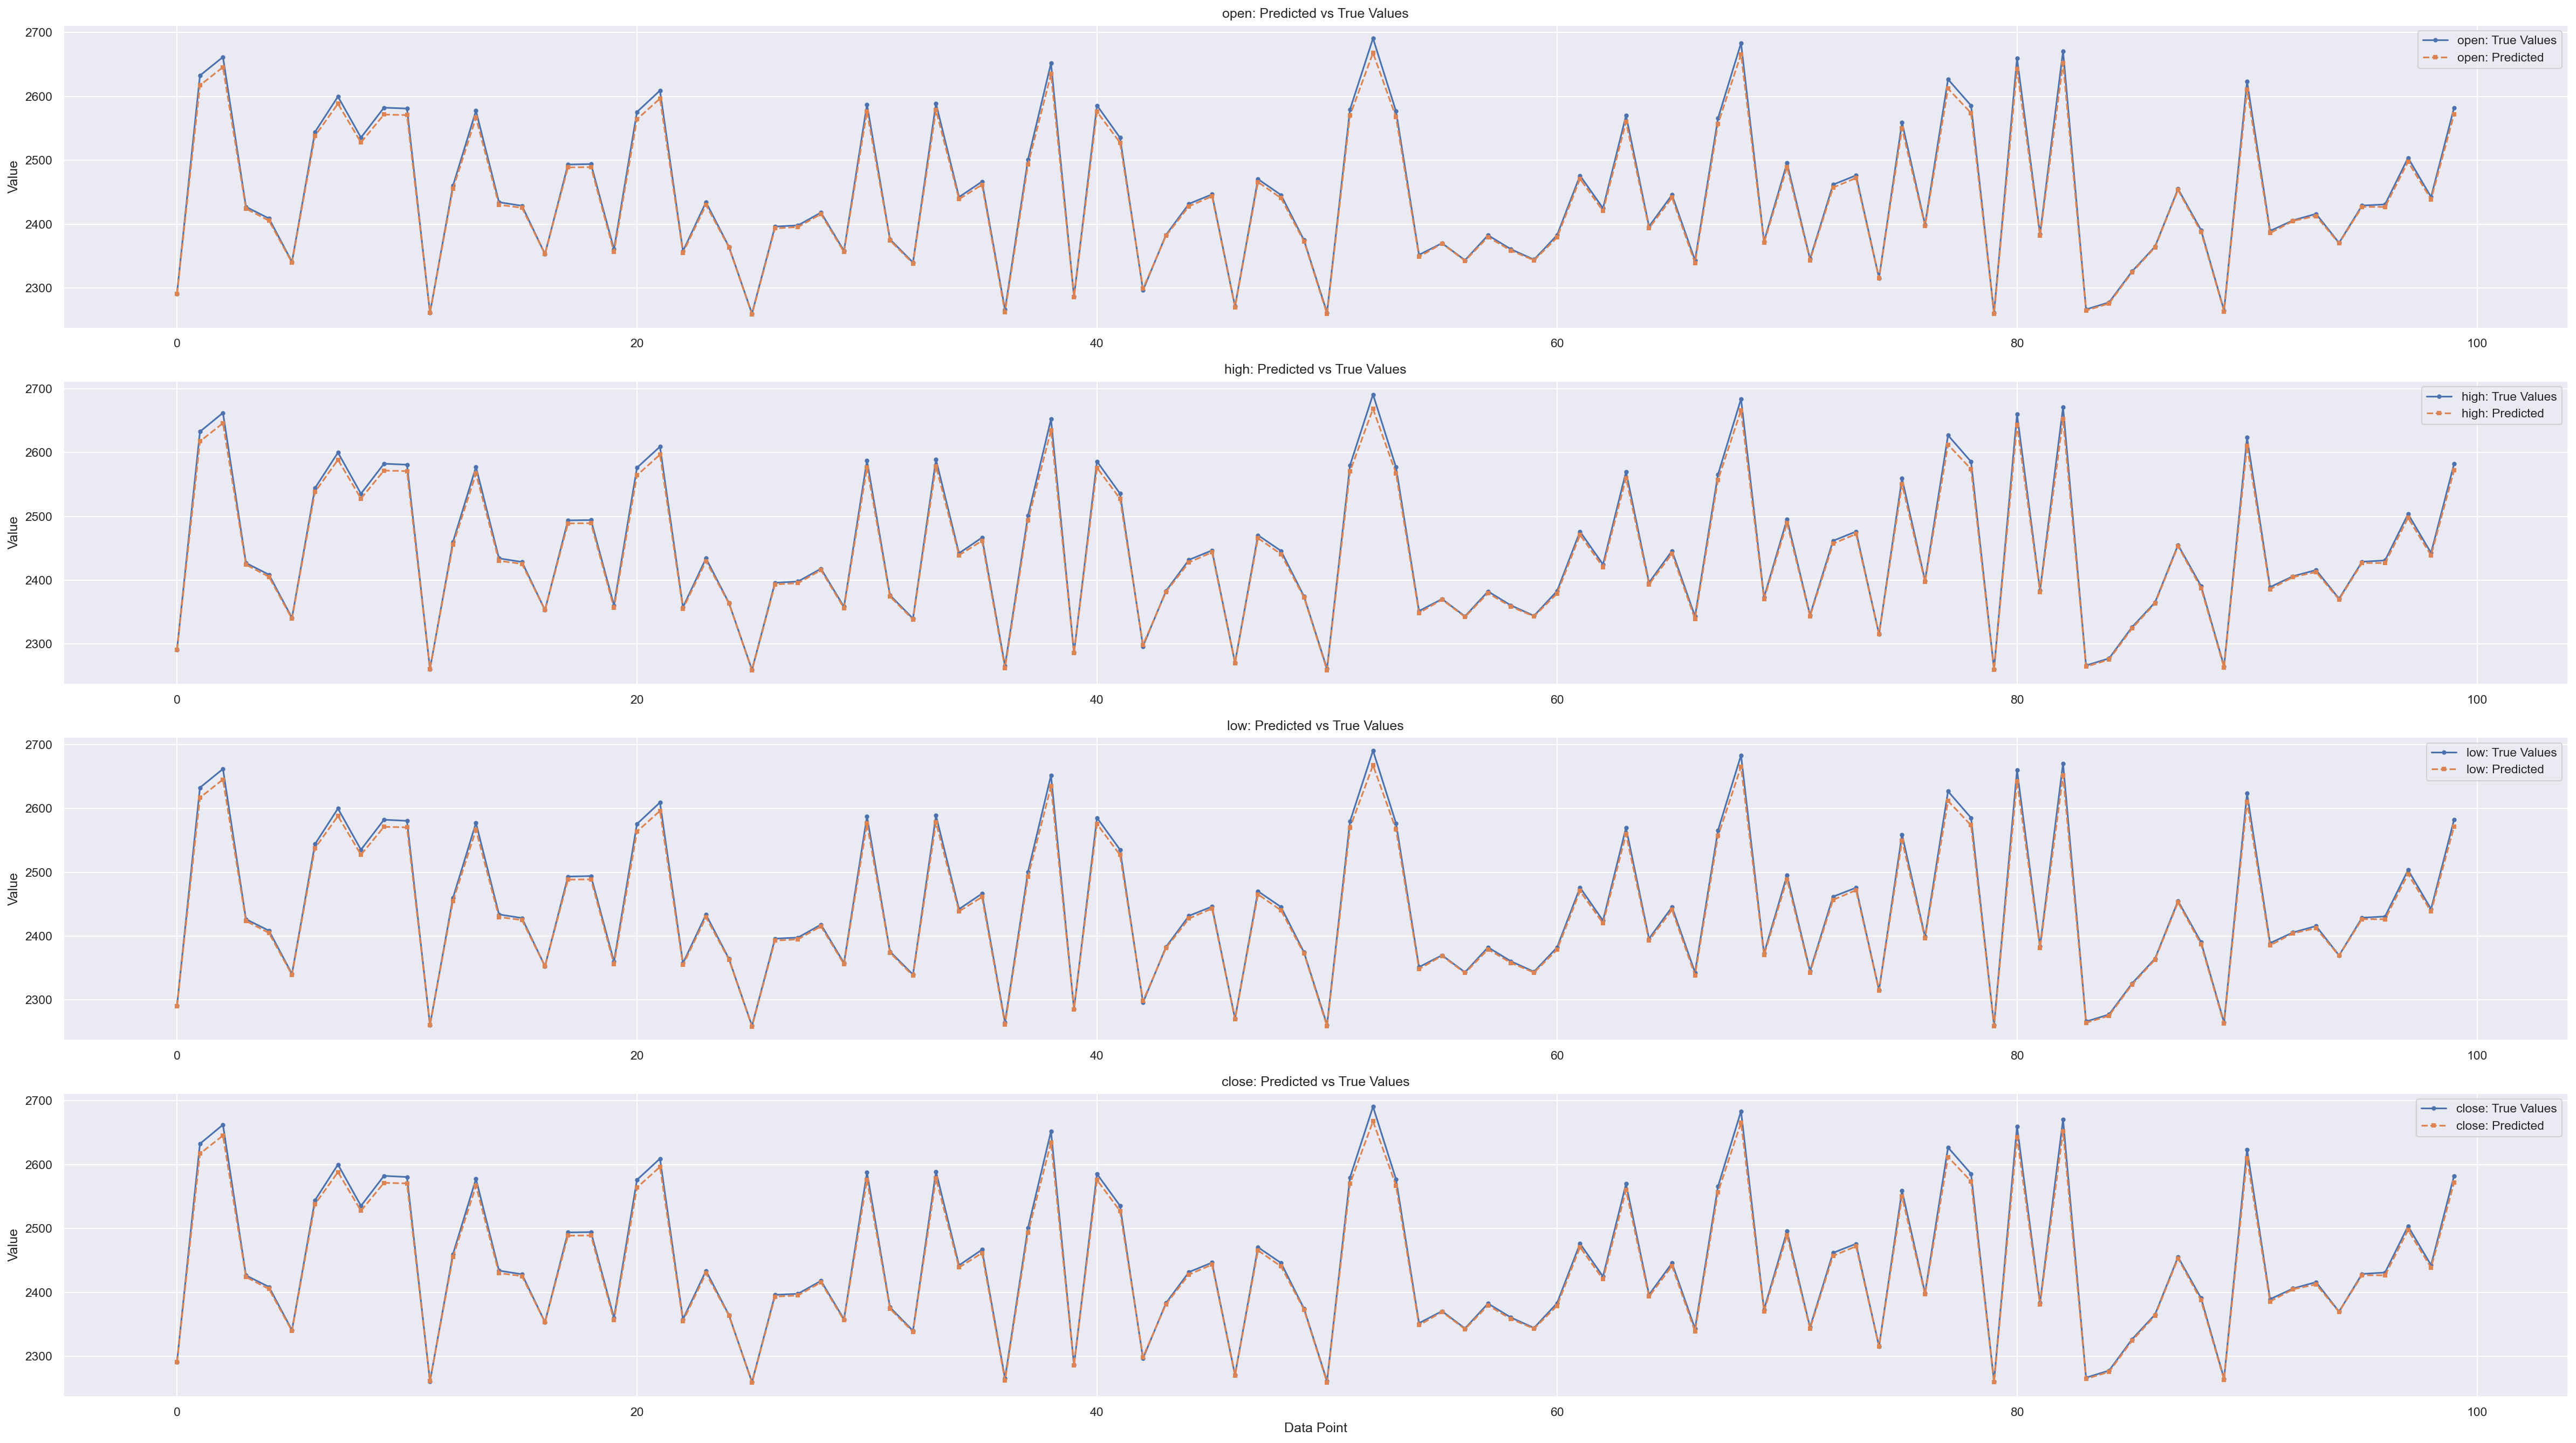

In [16]:
## 部分数据
num_features = y_test.shape[1]
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(32, 18), dpi=150)
feature_names = ['open', 'high', 'low', 'close']

num_data_points_to_show = 100

for i in range(num_features):
    axes[i].plot(y_test[:num_data_points_to_show, i], label=f'{feature_names[i]}: True Values', linestyle='-', marker='o', markersize=3)
    axes[i].plot(y_pred_test[:num_data_points_to_show, i], label=f'{feature_names[i]}: Predicted', linestyle='--', marker='s', markersize=3)

    axes[i].set_title(f'{feature_names[i]}: Predicted vs True Values')
    axes[i].set_ylabel('Value')
    if i == num_features - 1:
        axes[i].set_xlabel('Data Point')
    axes[i].legend()

plt.tight_layout()
plt.savefig(fname='CNN-BiGRU-Attention前一百个数据情况.png')